In [1]:
from IPython.core.debugger import set_trace

import pandas as pd
import re
import numpy as np
# from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import matplotlib
from bs4 import BeautifulSoup
import urllib
from pprint import pprint
import pickle
import os
from collections import Counter
import nltk
import random
from html.parser import HTMLParser
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import string
from scipy.sparse import csr_matrix, vstack

import fasttext as ft
import spacy

# Load in recent100 dataset of descriptions

In [4]:
desc_data = pd.read_csv('/usr0/home/mamille2/tumblr/data/blog_descriptions_recent100.csv', error_bad_lines=False)
print(len(desc_data))
print(desc_data.columns)

b'Skipping line 45448: expected 16 fields, saw 31\nSkipping line 56198: expected 16 fields, saw 31\n'
b'Skipping line 94744: expected 16 fields, saw 31\n'
b'Skipping line 154629: expected 16 fields, saw 17\n'
b'Skipping line 365167: expected 16 fields, saw 31\n'
b'Skipping line 443895: expected 16 fields, saw 31\nSkipping line 447956: expected 16 fields, saw 31\n'
b'Skipping line 606290: expected 16 fields, saw 32\n'
b'Skipping line 751242: expected 16 fields, saw 31\n'
b'Skipping line 858344: expected 16 fields, saw 20\n'
b'Skipping line 943141: expected 16 fields, saw 31\n'
b'Skipping line 1205524: expected 16 fields, saw 31\n'
b'Skipping line 1249996: expected 16 fields, saw 31\n'
b'Skipping line 1453947: expected 16 fields, saw 31\nSkipping line 1456673: expected 16 fields, saw 31\n'
b'Skipping line 1770383: expected 16 fields, saw 31\n'
b'Skipping line 1809473: expected 16 fields, saw 17\n'
b'Skipping line 1974849: expected 16 fields, saw 31\n'
b'Skipping line 2075999: expected 16

6319778
Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date'],
      dtype='object')


In [6]:
# Filter out empty and numeric blog descriptions
desc_data = desc_data[desc_data['tumblr_blog_description'].map(lambda x: isinstance(x, str) and len(x) > 0)]
len(desc_data)

6319685

In [7]:
# Save out
desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/blog_descriptions_recent100.pkl')

# Prepare description segments for annotation of category mentions

In [180]:
# Filter out empties (segments all too long)
print(len(list_desc_data))
filtered = list_desc_data[list_desc_data['restr_segments_25'].map(lambda x: len(x) > 0)]
len(filtered)

705025


599771

In [181]:
filtered.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description', 'segments', 'restr_segments_25'],
      dtype='object')

In [183]:
filtered.loc[:,['tumblog_id','restr_segments_25']]

,tumblog_id,restr_segments_25
6,13215.0,"[wearetheclarks-com, temp design portfolio]"
22,49178.0,[glad to see you made it]
34,77148.0,"[for i, am, ben]"
50,125102.0,"[hello, i'm eric, enjoy]"
62,168058.0,[organize your life]
92,268960.0,[plus some other crap]
93,270957.0,[and that includes you!]
106,302924.0,"[otro espacio, espero conservarlo]"
127,372853.0,[glass]
138,428797.0,[your mileage may vary]


# Prepare description segments for Brown clustering (and other thgs)

In [171]:
# Filter spam
rm_list = [
    'relax and watch!',
    'my snapChat: lovewet9x',
    '/_        @will4i20    _\\',
    'my snapchat: sexybaby9x'
#     'Please wait' # not sure about this one
]

In [176]:
# Get list of descs to cluster
char_limit = 25
list_desc_data[f'restr_segments_{char_limit}'] = list_desc_data['segments'].map(
    lambda d: [s for s in d if (len(s) <= char_limit and len(s) > 1) if not s in rm_list]
    )

In [177]:
list_desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions.pkl')

In [175]:
descs = [' '.join(d) for d in list_desc_data[f'restr_segments_{char_limit}'].tolist() if len(d) > 0]
print(len(descs))
descs

600152


['wearetheclarks-com temp design portfolio',
 'glad to see you made it',
 'for i am ben',
 "hello i'm eric enjoy",
 'organize your life',
 'plus some other crap',
 'and that includes you!',
 'otro espacio espero conservarlo',
 'glass',
 'your mileage may vary',
 'bits and pieces',
 'this is free text please comment',
 'adventures in sex adventure is sex',
 'last fm blip',
 "i'm twenty one",
 '18 socal rip coach eddie',
 'okay so listen',
 "i make music i scribble down words i laugh uncontrollably i am clumsy i cry when i'm sad and overjoyed i make mistakes i don't regret them i believe i have friends i exist",
 '- confucius',
 'everything i like',
 'wtf hell yeah!',
 "hi! it's me kim :)",
 'nothing',
 'my random thoughts',
 'travel friends me',
 "=]] vietnamese origin vietnamese ='')",
 'for anyone who cares!',
 '22 pesco-veggie intellect to the unknown',
 "i'm nissa! i'm 19 i love love love music let's be friends",
 'inside looking outside outside looking inside reverse',
 "that's wha

In [133]:
# Filter to just terms occurring more than once
wds = [w for d in descs for w in d.split()]
len(wds)

2836490

In [135]:
wd_ctr = Counter(wds)
vocab = [w for w in wd_ctr if wd_ctr[w] > 1]
len(vocab)

84458

In [138]:
# descs_freq = [w for d in descs for w in d.split() if w in vocab]
descs_freq = []
for d in tqdm(descs):
    newd = []
    for w in d.split():
        if w in vocab:
            newd.append(w)
    descs_freq.append(' '.join(newd))
            
descs_freq[:100]

HBox(children=(IntProgress(value=0, max=650354), HTML(value='')))

['',
 'jim presents',
 'would you like a',
 'hello',
 'make it a double',
 'for i am ben',
 'we are always',
 "hello i'm eric enjoy",
 'organize your life',
 'plus some other crap',
 'otro espacio espero',
 'www com',
 'glass',
 'our life so far',
 'bits and pieces',
 'things i do daily',
 'this is free text please comment',
 'adventures in sex adventure is sex',
 'last fm blip',
 "i'm twenty one",
 '18 socal rip coach eddie',
 'okay so listen',
 "i make music i am clumsy i cry when i'm sad and overjoyed i make mistakes i don't regret them i believe i have friends i exist",
 '- confucius',
 'everything i like',
 'wtf hell yeah!',
 "hi! it's me kim :)",
 'nothing',
 'my random thoughts',
 'travel friends me',
 'vietnamese',
 'tumblr',
 '22',
 "i'm i'm 19 let's be friends",
 'randomness',
 'reverse',
 'www com/blog',
 '- boy meets world',
 'oib com}',
 "hi i'm kaitlyn welcome to my mind",
 'my name is bri but not always',
 'fashion art design architecture music life',
 'http:',
 'create 

In [139]:
descs_freq = [d for d in descs_freq if len(d) > 0]
len(descs_freq)

637433

In [141]:
# Save out for Brown clustering
with open('/usr0/home/mamille2/tumblr/data/desc_segments_20_freq.txt', 'w') as f:
    for d in descs_freq:
        f.write(d + '\n')

# Process URLs (to hyphens) so don't interact with list descriptions

In [2]:
# Load descriptions

desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
print(desc_data.columns)
print(len(desc_data))

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description'],
      dtype='object')
4617128


In [7]:
url_descs = desc_data[desc_data['parsed_blog_description'].map(lambda x: 'http' in x)]['parsed_blog_description']
url_descs

58                                                                                                                                                                                                                              Various things said and seen by Anthony Zacharzewski that are not part of the day job (which is http://demsoc.org)
167                                                                                                                                                                                                                                                                                                               the tumblelog of  http://kabl.am
343                                                                                                                                                                                                                                                                                                                       http://w

In [6]:
pd.set_option('display.max_colwidth', 999)

In [50]:
test = 'https://www.instagram.com/_candemansilla_/ http://sthg.else'

# test = ''.join(re.split(r'https?:\/\/', test)).strip()

# replacements = [] # (beg_idx,end_idx): replacement
for el in re.finditer(r'https?:\/\/\S*', test):
#     print(dir(el))
    m = el.group()
    test = test.replace(m, process_url(m))
#     print(el.__attr__())
#     replacements[sp] = process_url(test[sp[0]:sp[1]])
#     test = test[]
    
# for sp, r in replacements:
    
    
test

instagram-com/_candemansilla_/
instagram-com/_candemansilla_
sthg-else
sthg-else


'instagram-com/_candemansilla_ sthg-else'

In [84]:
def process_url(url):
    url = re.sub(r'https?:\/\/', '', url).replace('www.','').replace('.', '-')
    url = re.sub(r'\/$', '', url).replace('/', '-')
    return url

In [88]:
def process_urls(desc):
    processed = desc
    
    for m in re.finditer(r'\S+(?:\.com|\.org|\.edu)\S*|https?:\/\/\S*', desc):
        processed = processed.replace(m.group(), process_url(m.group()))
    
#     for m in re.finditer(r'https?:\/\/\S*', test):
#         processed = processed.replace(m.group(), process_url(m.group()))
        
    return processed

In [89]:
# test = 'https://www.instagram.com/_candemansilla_/ http://sthg.else | wearetheclarks.com'
# test = 'Various things said and seen by Anthony Zacharzewski that are not part of the day job (which is http://demsoc.org)'
test = 'this is the tumblr for Matthew Brady Clark photos | wearetheclarks.com/blog | temp design portfolio'
# test = 'Find me on sthg.tumblr.com'
process_urls(test)

'this is the tumblr for Matthew Brady Clark photos | wearetheclarks-com-blog | temp design portfolio'

In [113]:
parsed = list(map(process_urls, tqdm(desc_data['parsed_blog_description'].tolist())))
parsed

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

['This is a quick blog',
 'This makes no CENTS  Go Figure',
 'Call 206-312-4SNURKS to leave a message.',
 'asdflkasjflk',
 'This is not so clear',
 'random musings',
 'this is the tumblr for Matthew Brady Clark photos | wearetheclarks-com | temp design portfolio',
 "Jared's! great you should be too.",
 'Vivere in  rosa.',
 'A personal collection of moments',
 'Sciame\xa0internettico di  caracaterina',
 'A focal point for archives and experience.   Drilled from the depths of the data mine.',
 "Welcome to our wedding blog! We'll do our best to keep this updated over the next few months...",
 'Jim Ventola presents...',
 'the daily events of a small village community',
 'Would you like a ...',
 'Test it baby ;-)',
 'shiny shimmery sparkles.',
 'tasty notes and jottings to the memory',
 'yet another notebook.',
 'italian workgroup about : internet and web technologies',
 'Faculdade de Belas Artes da Univerdade do Porto Universidade Júnior 2007 - Oficinas de Verão',
 "Glad to see you made it

In [118]:
desc_data['parsed_blog_description'] = parsed
desc_data['parsed_blog_description']

0                                                                                                                                              This is a quick blog
1                                                                                                                                    This makes no CENTS  Go Figure
2                                                                                                                          Call 206-312-4SNURKS to leave a message.
3                                                                                                                                                      asdflkasjflk
4                                                                                                                                              This is not so clear
5                                                                                                                                                    random musings
6               

In [120]:
desc_data.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description', 'parsed_blog_descriptions'],
      dtype='object')

In [121]:
desc_data.drop('parsed_blog_descriptions', axis=1, inplace=True)

In [122]:
desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')

# Process dates so don't interact with list descriptions

In [2]:
# Load descriptions

desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
print(desc_data.columns)
print(len(desc_data))

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description'],
      dtype='object')
4617128


In [157]:
date_p = re.compile(r'(?:\d{4}|\d{2})(?:\.|\/)\d{2}(?:\.|\/)(?:\d{4}|\d{2})')
def has_date(desc):
    if isinstance(desc, str):
        return re.match(date_p, desc)
    else:
        return None

In [161]:
date_descs = [d for d in list(map(has_date, tqdm(desc_data['parsed_blog_description']))) if d is not None]
len(date_descs)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

3277

In [162]:
date_descs

[<_sre.SRE_Match object; span=(0, 10), match='03/12/1996'>,
 <_sre.SRE_Match object; span=(0, 10), match='30/11/2011'>,
 <_sre.SRE_Match object; span=(0, 8), match='12.31.11'>,
 <_sre.SRE_Match object; span=(0, 10), match='09/10/2012'>,
 <_sre.SRE_Match object; span=(0, 8), match='08.22.14'>,
 <_sre.SRE_Match object; span=(0, 8), match='11.18.15'>,
 <_sre.SRE_Match object; span=(0, 8), match='11/10/14'>,
 <_sre.SRE_Match object; span=(0, 10), match='18/07/2014'>,
 <_sre.SRE_Match object; span=(0, 10), match='27/08/1980'>,
 <_sre.SRE_Match object; span=(0, 8), match='12.11.13'>,
 <_sre.SRE_Match object; span=(0, 10), match='17.05.2014'>,
 <_sre.SRE_Match object; span=(0, 10), match='04.12.2014'>,
 <_sre.SRE_Match object; span=(0, 10), match='17.10.2013'>,
 <_sre.SRE_Match object; span=(0, 10), match='15.03.2017'>,
 <_sre.SRE_Match object; span=(0, 10), match='19/06/2014'>,
 <_sre.SRE_Match object; span=(0, 8), match='11/14/98'>,
 <_sre.SRE_Match object; span=(0, 10), match='25.04.2014'>

In [164]:
def process_dates(desc):
    processed = desc
    date_p = re.compile(r'(?:\d{4}|\d{2})(?:\.|\/)\d{2}(?:\.|\/)(?:\d{4}|\d{2})')
    
    for m in re.finditer(date_p, desc):
        processed = processed.replace(m.group(), process_date(m.group()))
    
    return processed

In [163]:
def process_date(datestr):
    return datestr.replace('/', '-').replace('.', '-')

In [165]:
test = 'wedding 15.03.2017'
process_dates(test)

'wedding 15-03-2017'

In [167]:
date_data = desc_data[desc_data['parsed_blog_description'].map(lambda x: has_date(x) is not None)]
print(len(date_data))
date_data

3277


,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date,parsed_blog_description,tokenized_blog_description
7995,33702489.0,1.461216e+12,akidnamedwiz,NaN,<p>03/12/1996</p>,http://akidnamedwiz.tumblr.com/,NaN,false,true,false,1320645562000,1441997390000,US/Eastern,en_US,NaN,20171119,03/12/1996,[03/12/1996]
8464,35688505.0,1.484105e+12,30novembrohappybday-blog,HAPPY BIRTHDAY,30/11/2011 (^),http://30novembrohappybday-blog.tumblr.com/,NaN,false,true,false,1322442533000,1484104798000,US/Eastern,en_US,safe,20171119,30/11/2011 (^),"[30/11/2011, (, ^, )]"
13940,62627535.0,1.445617e+12,cassilovesdominic-blog,Dommybear ღ,12.31.11♡,http://cassilovesdominic-blog.tumblr.com/,NaN,false,true,false,1341398061000,1445617138000,US/Eastern,en_US,NaN,20171119,12.31.11♡,[12.31.11♡]
17804,92939193.0,1.480719e+12,forever-is-forever-with-you-blog,I Love You ∞,09/10/2012,http://forever-is-forever-with-you-blog.tumblr.com/,NaN,false,true,false,1360258084000,1476217908000,US/Eastern,en_US,safe,20171119,09/10/2012,[09/10/2012]
19009,102900222.0,1.489968e+12,faziaaa,f.s,<p><strong>08.22.14</strong></p>,https://faziaaa.tumblr.com/,NaN,false,true,false,1366031736000,1489967652000,US/Eastern,en_US,safe,20171119,08.22.14,[08.22.14]
19141,103813309.0,1.446616e+12,whoare1d,thank you zayn,<p>11.18.15</p>,http://whoare1d.tumblr.com/,NaN,false,true,false,1366574794000,1438534269000,US/Eastern,en_US,NaN,20171119,11.18.15,[11.18.15]
21323,122304799.0,1.508684e+12,andresmotionless,Bands/life/and my girlfriend❤,11/10/14❤,http://andresmotionless.tumblr.com/,NaN,false,true,false,1373415988000,1508683670000,US/Eastern,en_US,safe,20171119,11/10/14❤,[11/10/14❤]
21492,124084018.0,1.476143e+12,samiiiiiiiiiiiiiiiiiiiiiii-blog1,Sami,<p>18/07/2014</p>,http://samiiiiiiiiiiiiiiiiiiiiiii-blog1.tumblr.com/,NaN,false,true,false,1373946032000,1476142934000,US/Eastern,en_US,safe,20171119,18/07/2014,[18/07/2014]
25556,143989093.0,1.489833e+12,ipatriciasyf,The reality of the life.,27/08/1980. 31/08/1981.,https://ipatriciasyf.tumblr.com/,NaN,false,true,false,1383168151000,1489833224000,US/Eastern,en_US,safe,20171119,27/08/1980. 31/08/1981.,"[27/08/1980, ., 31/08/1981, .]"
28774,167036025.0,1.489810e+12,jerrypalabanda,Francisca J'aviera,12.11.13♥BT♥,https://jerrypalabanda.tumblr.com/,NaN,false,true,false,1390190694000,1489809987000,US/Eastern,en_US,safe,20171119,12.11.13♥BT♥,[12.11.13♥bt♥]


In [168]:
processed = date_data['parsed_blog_description'].map(process_dates)
processed

7995                                                                                                                                                                                                                       03-12-1996
8464                                                                                                                                                                                                                   30-11-2011 (^)
13940                                                                                                                                                                                                                       12-31-11♡
17804                                                                                                                                                                                                                      09-10-2012
19009                                                                           

In [169]:
desc_data['parsed_blog_description'] = desc_data['parsed_blog_description'].map(process_dates)
desc_data['parsed_blog_description']

0                                                                                                                                              This is a quick blog
1                                                                                                                                    This makes no CENTS  Go Figure
2                                                                                                                          Call 206-312-4SNURKS to leave a message.
3                                                                                                                                                      asdflkasjflk
4                                                                                                                                              This is not so clear
5                                                                                                                                                    random musings
6               

In [170]:
desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')

# Extract 'list descriptors'

In [111]:
# Load descriptions

desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
print(desc_data.columns)
print(len(desc_data))

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description', 'parsed_blog_descriptions'],
      dtype='object')
4617128


In [124]:
seps = ['|', '/', '\\', '.']
desc_re = '|'.join([r'^.*\{0}.+\{0}.*$'.format(s) for s in seps])
desc_re

'^.*\\|.+\\|.*$|^.*\\/.+\\/.*$|^.*\\\\.+\\\\.*$|^.*\\..+\\..*$'

In [125]:
def is_list_desc(in_str):
    if re.search(desc_re, in_str):
        return True
    else:
        return False

In [126]:
mask = list(map(is_list_desc, tqdm(desc_data['parsed_blog_description'].tolist())))
list_desc_data = desc_data[mask]
len(list_desc_data)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

800717

In [140]:
# Investigate whether adult blogs should stay (lots of diversity, so should)
list_desc_data.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date', 'parsed_blog_description',
       'tokenized_blog_description', 'segments'],
      dtype='object')

In [142]:
list_desc_data['blog_classifier'].unique()

array([nan, 'safe', 'adult', 'http://raridadeslovato-blog.tumblr.com/'], dtype=object)

In [143]:
list_desc_data[list_desc_data['blog_classifier']=='adult']['parsed_blog_description']

1069                                                                                                                                                                                                          im 14. i like poetry both to read and write.  i live in jersey. i play football and baseball.
1487                                                                                                              My names Christine Jacquelyne Gonzalez. i dont care what you say about me. im as lost as a new born puppie. my life is to hectic for me to control. im in love. [we are no longer dating]
1591                                                                                                                                                                     I dont own any of the pics. If your under 18 please leave. If you own any of the pics i post  send Me a note and I'll take it down
1701                                                                                                

In [127]:
list_desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions.pkl')

## Segment lists

In [146]:
def segment_desc(desc):
    delims = ['|', '/', '.', '\\']
    
    # take max segmentation length to select delimiter (may be a bit inefficient)
    delim_ctr = {d: desc.count(d) for d in delims}
    sep = sorted(delim_ctr, key=delim_ctr.get, reverse=True)[0]
    
    return [el.strip().lower() for el in desc.split(sep) if len(el) > 0 and el != ' ']

In [17]:
segment_desc('this is my tumblr.blog | its me | im great')

['this is my tumblr.blog', 'its me', 'im great']

In [18]:
segment_desc('this is my tumblr.blog | its me. | im great')

['this is my tumblr.blog', 'its me.', 'im great']

In [19]:
segment_desc('this is my tumblr blog / its me. / im great')

['this is my tumblr blog', 'its me.', 'im great']

In [23]:
segment_desc('this is my tumblr blog // its me. // im great')

['this is my tumblr blog', 'its me.', 'im great']

In [45]:
segment_desc('this is my tumblr blog \ its me. \ im great')

['this is my tumblr blog', 'its me.', 'im great']

In [147]:
list_desc_data['segments'] = list(map(segment_desc, tqdm(list_desc_data['parsed_blog_description'].tolist())))

HBox(children=(IntProgress(value=0, max=705025), HTML(value='')))

In [148]:
# Remove lines with 0 or 1 segments

list_desc_data = list_desc_data[list_desc_data['segments'].map(lambda x: len(x) > 1)]
len(list_desc_data)

705025

In [149]:
list_desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/list_descriptions.pkl')

## Visualize data

In [62]:
segment_nums = [len(s) for s in list_desc_data['segments']]

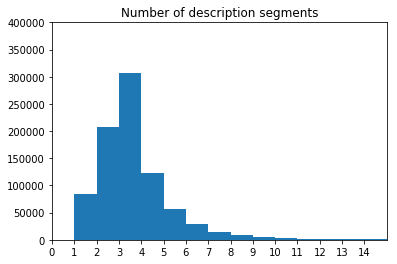

In [69]:
%matplotlib inline

# Histogram of number of segments

plt.hist(segment_nums, bins=np.arange(min(segment_nums), max(segment_nums)+1, 1))
plt.title("Number of description segments")
plt.axis([1,15,0,int(4e5)])
plt.xticks(range(15))
plt.savefig('/usr0/home/mamille2/tumblr/results/num_desc_segments.png', dpi=300)
plt.show()

In [107]:
segs = [s for seg in list_desc_data['segments'].tolist() for s in seg]
len(segs)

2636321

In [71]:
seg_lens = [len(s) for s in segs]

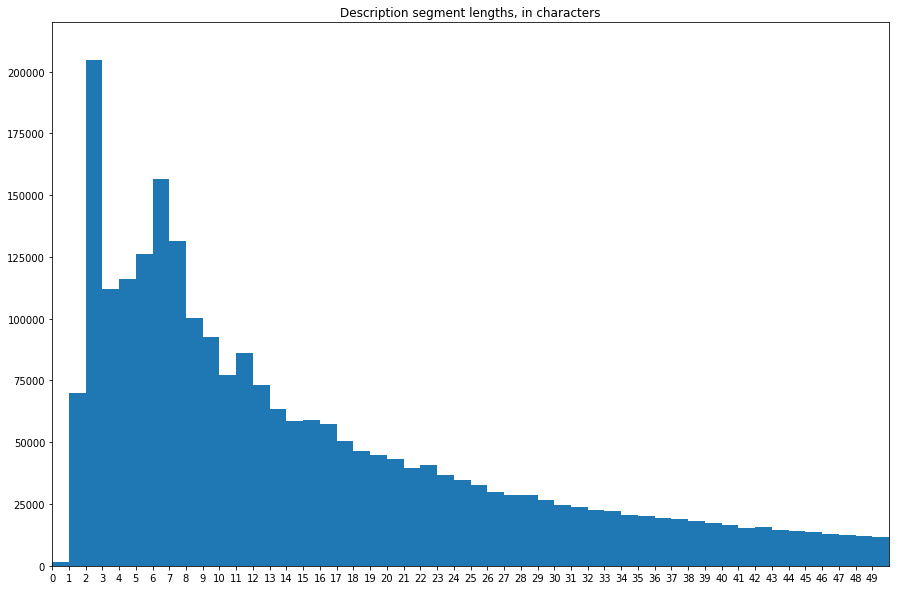

In [78]:
%matplotlib inline

# Histogram of segment lengths

fig = plt.figure(figsize=(15,10))
plt.hist(seg_lens, bins=np.arange(min(seg_lens), max(seg_lens)+1, 1))
plt.title("Description segment lengths, in characters")
x_max = 50
plt.axis([1, x_max, 0, int(2.2e5)])
plt.xticks(range(x_max))
plt.savefig('/usr0/home/mamille2/tumblr/results/desc_segments_lens.png', dpi=100)
plt.show()

## Restrict length of segments

In [150]:
segs = [s for seg in list_desc_data['segments'].tolist() for s in seg]
len(segs)

2439946

In [135]:
# Explore diff segment sizes
egs = {}
for char_limit in [10,15,20,25,30]:
    egs[char_limit] = [r for r in segs if len(r) == char_limit]
    
len(egs)

5

In [139]:
egs[25]

['Manusia biasa yang narsis',
 'Aber auch echt nur selten',
 'Still searching & looking',
 'Blogging about daily life',
 "This is why I'm unhealthy",
 'at least the way I see it',
 '[we are no longer dating]',
 "But please don't abuse it",
 'Going to live in New York',
 'Yna Estefany Del Castillo',
 'California born and raisd',
 'This is the place for you',
 'Moscow Art Theatre School',
 'Hi just checking this out',
 'Aim high and trust in God',
 '(Sometimes subconsciously',
 'i LOVE the boston celtics',
 'i just think im outspoken',
 "I don't smoke but i drink",
 'Wassup? My name is Jariel',
 'And coffee and adventures',
 'Play music and tacos rule',
 'Never take life seriously',
 'A quick glance of my life',
 'Donation female exclusive',
 'hustling for a better one',
 'Professional PhotograpHER',
 'My name is Chelsea Dreyer',
 'i usually love chocolates',
 'I also love playing piano',
 'This is my online journal',
 "You may say I'm a dreamer",
 'Has only made me stronger',
 '<  3   <

In [151]:
# Restrict length of segments
restr_segs= {}
char_limit = 25
restr_segs[char_limit] = [r for r in segs if len(r) <= char_limit and len(r) > 1]
print(len(restr_segs[char_limit]))
print(len(set(restr_segs[char_limit])))

# Get a feel for restr_segs
restr_segs_ctr = {}
restr_segs_ctr[char_limit] = Counter(restr_segs[char_limit])
restr_segs_ctr[char_limit].most_common()

1675452
610762


[('18', 17979),
 ('17', 17214),
 ('16', 16917),
 ('19', 13858),
 ('15', 13418),
 ('20', 10757),
 ('21', 8860),
 ('14', 8336),
 ('22', 6476),
 ('music', 5876),
 ('nsfw', 5599),
 ('she/her', 5192),
 ('23', 4801),
 ('love', 4357),
 ('13', 4267),
 ('female', 4151),
 ('hi', 3908),
 ('art', 3624),
 ('fashion', 3536),
 ('24', 3372),
 ('single', 3290),
 ('photography', 3094),
 ('uk', 2853),
 ('writer', 2725),
 ('artist', 2718),
 ('male', 2621),
 ('my snapchat: lovewet9x', 2592),
 (':)', 2564),
 ('bi', 2521),
 ('25', 2459),
 ('bisexual', 2266),
 ('food', 2209),
 ('enjoy', 2158),
 ('18+', 2147),
 ('she', 2139),
 ('gay', 2136),
 ('hello', 2086),
 ('relax and watch!', 2086),
 ('only 18++', 2086),
 ('taken', 2067),
 ('life', 2021),
 ('lesbian', 2015),
 ('student', 2007),
 ('he/him', 1966),
 ('18+ only', 1886),
 ('12', 1853),
 ('photographer', 1815),
 ('they/them', 1788),
 ('girl', 1785),
 ('<  3', 1785),
 ('australia', 1741),
 ('anime', 1703),
 ('canada', 1685),
 ('www', 1642),
 ('26', 1620),
 ('ge

In [120]:
pd.set_option('display.max_rows', 50)

In [123]:
pd.set_option('display.max_colwidth', 999)

In [145]:
# Filter spam

rm_list = [
    'relax and watch!',
    'my snapChat: lovewet9x',
    '/_        @will4i20    _\\',
    'my snapchat: sexybaby9x'
#     'Please wait' # not sure about this one
]

In [126]:
with open('/usr0/home/mamille2/tumblr/data/desc_segments.pkl', 'wb') as f:
    pickle.dump(restr_segs, f)

In [125]:
# Investigate weird description segments
# eg = '01'
eg = 'Please wait'

# eg_data = list_desc_data[list_desc_data['segments'].map(lambda x: eg in x)].loc[:,['parsed_blog_description', 'segments']]
eg_data = list_desc_data[list_desc_data['segments'].map(lambda x: eg in x)]
print(len(eg_data))
eg_data

6027


,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date,parsed_blog_description,tokenized_blog_description,segments
74963,356530023.0,1.500584e+12,melbradburn88,Please wait...,Please wait...,https://melbradburn88.tumblr.com/,NaN,False,True,False,1500482205000,1500583525000,Europe/Amsterdam,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
74966,356536013.0,1.500584e+12,torricembura84,Please wait...,Please wait...,https://torricembura84.tumblr.com/,NaN,False,True,False,1500484944000,1500583525000,Europe/Amsterdam,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
74977,356559990.0,1.500501e+12,shanmodgling90,Please wait...,Please wait...,https://shanmodgling90.tumblr.com/,NaN,False,True,False,1500496191000,1500501305000,Europe/Paris,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75013,356635913.0,1.500670e+12,beccanesline73,Untitled,Please wait...,https://beccanesline73.tumblr.com/,NaN,False,True,False,1500536718000,1500670430000,Europe/Amsterdam,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75015,356639909.0,1.500670e+12,cletariffle78,Please wait...,Please wait...,https://cletariffle78.tumblr.com/,NaN,False,True,False,1500539457000,1500670453000,Europe/Amsterdam,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75069,356764786.0,1.500671e+12,rosalindamesch59,Untitled,Please wait...,https://rosalindamesch59.tumblr.com/,NaN,False,True,False,1500608688000,1500670579000,Europe/Paris,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75074,356778772.0,1.500927e+12,christietaborn90,Please wait...,Please wait...,https://christietaborn90.tumblr.com/,NaN,False,True,False,1500616525000,1500927178000,Europe/Paris,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75083,356796753.0,1.500927e+12,jacinthflemmings74,Untitled,Please wait...Please wait...,https://jacinthflemmings74.tumblr.com/,NaN,False,True,False,1500628095000,1500927121000,Europe/Paris,en_US,safe,20171122,Please wait...Please wait...,"[please, wait, ..., please, wait, ...]","[Please wait, Please wait]"
75092,356818734.0,1.500927e+12,coletteharpe97,Please wait...,Please wait...,https://coletteharpe97.tumblr.com/,NaN,False,True,False,1500643150000,1500927121000,Europe/Paris,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]
75094,356819733.0,1.500927e+12,lucasvaux93,Please wait...,Please wait...,https://lucasvaux93.tumblr.com/,NaN,False,True,False,1500643764000,1500927121000,Europe/Paris,en_US,safe,20171122,Please wait...,"[please, wait, ...]",[Please wait]


## Remove HTML markup

In [32]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

def preprocess_post(post):
    
    # Strip html tags
    nohtml = strip_tags(post)
    
    # Tokenize with spaCy
    toks = [tok.text for tok in nlp.tokenizer(nohtml.lower())]
    
    # Remove whitespace tokens
    toks = [t for t in toks if not all(c==' ' for c in t)]
    
    return toks

In [36]:
desc_data['parsed_blog_description'] = desc_data['parsed_blog_description'].map(strip_tags)

In [37]:
desc_data.to_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')

# Make dataset for Tumblr word embedding training

In [2]:
# Load 27M posts (73GB)
data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent100.pkl')
print(data.columns)
print(len(data))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags'],
      dtype='object')
27342192


In [3]:
# Initialize tokenizer
nlp = spacy.load('en')

In [4]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

def preprocess_post(post):
    
    # Strip html tags
    nohtml = strip_tags(post)
    
    # Tokenize with spaCy
    toks = [tok.text for tok in nlp.tokenizer(nohtml.lower())]
    
    # Remove whitespace tokens
    toks = [t for t in toks if not all(c==' ' for c in t)]
    
    return toks

In [6]:
# Tokenize, preprocess all posts
data['body_toks'] = list(map(preprocess_post, tqdm(data['body'].tolist())))
data['body_toks'].head()

HBox(children=(IntProgress(value=0, max=27342192), HTML(value='')))

KeyboardInterrupt: 

# Select blog description embeddings that have 5 recent text posts

In [2]:
recent5 = pd.read_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')
print(recent5.columns)
print(len(recent5))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'body_toks'],
      dtype='object')
542060


In [3]:
# Should be the same order as when saved out the 5 recent text post embeddings
tids = []

for tid, row_inds in tqdm(recent5.groupby('tumblog_id').groups.items()):
    tids.append(tid)
    
print(len(tids))
tids == sorted(tids)

HBox(children=(IntProgress(value=0, max=108412), HTML(value='')))


108412


True

In [4]:
# Load blog descriptions
desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
len(desc_data)

4617128

In [17]:
# Load blog descriptions embeddings
desc_embed = np.load('/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy')
# desc_embed = np.load('/usr0/home/mamille2/tumblr/data/desc_embeddings_sum.npy')
desc_embed.shape

(4617128, 300)

In [5]:
# Get blog desc rows
desc_top5 = desc_data[desc_data['tumblog_id'].isin(tids)]
# len(desc_top5)

# Remove duplicates
desc_top5.drop_duplicates(subset=['tumblog_id'], inplace=True, keep='first')
len(desc_top5)

desc_top5.sort_values(['tumblog_id'], inplace=True)
top5_inds = desc_top5.index.tolist()
len(top5_inds)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


108412

In [6]:
# Save out desc_top5 dataframe
desc_top5.to_pickle('/usr0/home/mamille2/tumblr/data/desc_recent5.pkl')

In [19]:
selected = desc_embed[top5_inds]
selected.shape

(108412, 300)

In [20]:
np.save('/usr0/home/mamille2/tumblr/data/desc_recent5_avg.npy', selected)
# np.save('/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_sum.npy', selected)

# Preprocess data from Keith

In [3]:
recent5 = pd.read_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')
print(recent5.columns)
print(len(recent5))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'body_toks'],
      dtype='object')
553835


In [13]:
# Initialize tokenizer
nlp = spacy.load('en')

In [12]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

def preprocess_post(post):
    
    # Strip html tags
    nohtml = strip_tags(post)
    
    # Tokenize with spaCy
    toks = [tok.text for tok in nlp.tokenizer(nohtml.lower())]
    
    # Remove whitespace tokens
    toks = [t for t in toks if not all(c==' ' for c in t)]
    
    return toks

In [15]:
# Tokenize, preprocess all posts
recent5['body_toks'] = list(map(preprocess_post, tqdm(recent5['body'].tolist())))
recent5['body_toks'].head()

HBox(children=(IntProgress(value=0, max=553835), HTML(value='')))

0    [m86, :, parabins, :, is, it, gorillaz, or, th...
1    [marcelduchampsfountain, :, marcelduchampsfoun...
2    [softboydeluxe, :, carolxdanvers, :, queerwitc...
3                    [peoplegettingreallymadatfood, :]
4    [skyybridge, :, unsettlingstories, :, i, think...
Name: body_toks, dtype: object

In [8]:
# Filter out empty tokenized posts
recent5 = recent5[recent5['body_toks'].map(lambda x: len(x) > 0)]
counts = recent5.groupby('tumblog_id').size()
counts5 = counts[counts >= 5]
recent5 = recent5[recent5['tumblog_id'].isin(counts5.index)]
len(recent5)

542060

In [9]:
recent5.to_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')

## Embed posts

In [10]:
# wd_embed = ft.load_model('/usr0/home/mamille2/fasttext/en_wiki_stanford_model_300.bin')
wd_embed = ft.load_model('/usr0/home/mamille2/tumblr/data/halfday_ft.bin')

In [11]:
# Initialize variables
MAX_LEN = 300 # max word len for ea blog post
EMBED_LEN = 300
# unkvec = np.mean(np.array(list(wordvec[100000].values())), axis=0) # unk vector as avg

In [12]:
def post2vec(post, max_len, preprocessed=False):
    """ Takes post str or toks, returns vector """
    
    if not preprocessed:
        toks = preprocess_post(post)
    else:
        toks = post
    
    # Embed
    vec = np.mean(np.array([wd_embed[tok] for tok in toks[:max_len]]), axis=0)
#     vec = np.sum(np.array([wordvec[100000].get(tok, unkvec) for tok in toks[:max_len]]), axis=0)
    
    # Pad to get max_len
#     vec = np.pad(vec, ((0, max_len - vec.shape[0])), 'constant', constant_values=0)
    
    return vec

In [13]:
# Make embeddings of posts (training data)

post_embeds = []

for tid, row_inds in tqdm(recent5.groupby('tumblog_id').groups.items()):
    posts = recent5.loc[row_inds, 'body_toks']
    total_vec = np.hstack([post2vec(post, MAX_LEN, preprocessed=True) for post in posts])
#     assert total_vec.shape == (EMBED_LEN * 5,)
    if not total_vec.shape == (EMBED_LEN * 5,):
        set_trace()
    post_embeds.append(total_vec)
    
post_embeds = np.vstack(post_embeds)
post_embeds.shape

HBox(children=(IntProgress(value=0, max=108412), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



(108412, 1500)

In [14]:
# Save embeddings of posts (training data)
# np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embeds.npy', post_embeds)
# np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embeds_avg.npy', post_embeds)
# np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embed_sum.npy', post_embeds)
np.save('/usr0/home/mamille2/tumblr/data/recent5posts_embeds_avg.npy', post_embeds)

# Filter most recent 100 posts from Keith to just those with descriptions

In [10]:
# Load description usernames I want
with open('/usr0/home/mamille2/tumblr/data/endesc_ids.txt') as f:
    names = set([int(l) for l in f.read().splitlines()])

len(names)

4243638

In [3]:
# Load 27M posts (73GB)
data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent100.pkl')
print(data.columns)
print(len(data))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags'],
      dtype='object')
27349009


In [36]:
no_nans_inds = series_no_nan(data['tumblog_id'])
len(no_nans_inds)

27342192

In [37]:
data_filtered = data.loc[no_nans_inds]

In [35]:
def series_no_nan(s):
    nan_s = s.apply(no_nan)
    return nan_s[nan_s==True].index

In [34]:
def no_nan(thg):
    """ Get list of non-nan indices """
    
    if isinstance(thg, str) and len(thg) > 0 and thg.isdigit():
        return True
    
    elif isinstance(thg, int):
        return True
    
    elif isinstance(thg, float) and np.isfinite(thg):
        return True
        
    else:
        return False

In [39]:
# See username overlap with my set
data_filtered['tumblog_id'] = data_filtered['tumblog_id'].astype(int)
# recent100_tumblogs = set([int(t) for t in data_filtered['tumblog_id'].unique()])

In [40]:
data_filtered['tumblog_id'].dtype

dtype('int64')

In [41]:
# Save filtered data
data_filtered.to_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent100.pkl')

In [42]:
# See username overlap with my set
recent100_tumblogs = set(data_filtered['tumblog_id'].unique())
len(recent100_tumblogs)

2441596

In [44]:
len(names)

4243638

In [43]:
print(len(recent100_tumblogs.intersection(names)))

248399


In [47]:
# Load blog descriptions
desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
print(len(desc_data.columns))
len(desc_data)

4617128

In [49]:
# Check how many of those blogs I have descriptions for
desc_names = set(desc_data['tumblog_id'].unique())
len(recent100_tumblogs.intersection(desc_names))

248399

In [50]:
data_filtered = data_filtered[data_filtered['tumblog_id'].isin(desc_names)]
len(data_filtered)

2686039

In [52]:
# See how many posts/user
gped = data_filtered.groupby('tumblog_id')
recent5 = gped.size()[gped.size()>=5]
recent5

tumblog_id
59029         7
88494        18
97371        14
149407        8
165415        5
307918       10
338021        6
368478       46
377991       19
455165       64
534934       10
540269       27
599572        7
743538       35
758681        7
817880       13
829258       11
835861        9
851151       12
943255        6
990452       10
1003224       6
1014890      33
1029212       9
1128253       5
1161533       7
1164604      23
1168961      20
1179186       9
1180177      10
             ..
348628025     5
348630384     5
348632019     5
348632722     5
348641977     7
348643236     6
348645814    10
348649705     5
348654127     8
348657979    12
348659382     9
348659615    47
348661433     8
348670342     5
348672177     5
348687814     9
348688162     5
348700784     6
348703177    49
348705793     6
348712925     7
348716517     9
348716660     5
348719289     8
348722297     7
348723834    31
348723928     5
348743818    12
348745271     6
348749901    15
Length: 11076

In [55]:
recent5_data = data_filtered[data_filtered['tumblog_id'].isin(recent5.index)]
len(recent5_data)

2428057

In [56]:
recent5_data.to_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')

In [4]:
recent5_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')
print(recent5_data.columns)
print(len(recent5_data))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags'],
      dtype='object')
2428057


In [5]:
recent5_data.sort_values(['tumblog_id', 'activity_time_epoch'], inplace=True, ascending=False)
recent5_data

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,source_url,post_classifier,blog_classifier,accepts_answers,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,mentions,post_tags
15049187,161147652240,1495936230000,348749901,NaN,https://tmblr.co/Zl3apd2M59WYG,text,NaN,html,32059,1.49594e+12,...,https://parabins.tumblr.com/post/159027004721/...,safe,safe,False,1.61113e+11,"[root_post_id#159027004721,root_post_blog_id#9...",1.59027e+11,"<p><a href=""http://m86.tumblr.com/post/1590270...",{},{}
15049167,161147648975,1495936223000,348749901,NaN,https://tmblr.co/Zl3apd2M59VlF,text,NaN,html,49221,1.49594e+12,...,http://marcelduchampsfountain.tumblr.com/post/...,safe,safe,False,1.61113e+11,"[root_post_id#159731583799,root_post_blog_id#3...",1.59732e+11,"<p><a href=""http://marcelduchampsfountain.tumb...",{},{}
15048841,161147598595,1495936119000,348749901,NaN,https://tmblr.co/Zl3apd2M59JS3,text,NaN,html,469018,1.49594e+12,...,http://nblunalovegood.tumblr.com/post/10557229...,safe,safe,False,1.61144e+11,"[root_post_id#105572291038,root_post_blog_id#3...",1.05572e+11,"<p><a href=""http://softboydeluxe.tumblr.com/po...",{},{}
15048529,161147554145,1495936014000,348749901,NaN,https://tmblr.co/Zl3apd2M598bX,text,NaN,html,10197,1.49594e+12,...,http://peoplegettingreallymadatfood.tumblr.com...,safe,safe,False,1.60958e+11,"[root_post_id#159215447981,root_post_blog_id#3...",1.59215e+11,"<p><a href=""http://peoplegettingreallymadatfoo...",{},{}
15047988,161147467220,1495935823000,348749901,NaN,https://tmblr.co/Zl3apd2M58pNK,text,NaN,html,42749,1.49594e+12,...,http://unsettlingstories.tumblr.com/post/15778...,safe,safe,False,1.6106e+11,"[root_post_id#157787242176,root_post_blog_id#2...",1.57787e+11,"<p><a href=""http://skyybridge.tumblr.com/post/...",{},{}
15047652,161147418025,1495935715000,348749901,NaN,https://tmblr.co/Zl3apd2M58dMf,text,NaN,html,107761,1.49594e+12,...,http://fartgallery.tumblr.com/post/14994493032...,safe,safe,False,1.61145e+11,"[root_post_id#149944930322,root_post_blog_id#1...",1.49945e+11,"<p><a class=""tumblr_blog"" href=""http://fartgal...",{},{}
15047457,161147390745,1495935656000,348749901,NaN,https://tmblr.co/Zl3apd2M58WiP,text,NaN,html,45717,1.49594e+12,...,http://ifuckingguess.tumblr.com/post/159831401148,safe,safe,False,1.61147e+11,"[root_post_id#159831401148,root_post_blog_id#1...",1.59831e+11,"<p><a href=""http://ifuckingguess.tumblr.com/po...",{},{}
15047298,161147371155,1495935612000,348749901,NaN,https://tmblr.co/Zl3apd2M58RwJ,text,NaN,html,64161,1.49594e+12,...,http://memedad.tumblr.com/post/159906206375/me...,safe,safe,False,1.61145e+11,"[root_post_id#159906206375,root_post_blog_id#2...",1.59906e+11,"<p><a href=""http://memedad.tumblr.com/post/159...",{},{}
15046995,161147325005,1495935517000,348749901,NaN,https://tmblr.co/Zl3apd2M58GfD,text,NaN,html,63240,1.49594e+12,...,http://shmeards.tumblr.com/post/155134592264/m...,safe,safe,False,1.6049e+11,"[root_post_id#155134592264,root_post_blog_id#2...",1.55135e+11,"<p><a href=""http://shmeards.tumblr.com/post/15...",{},{}
15046967,161147322730,1495935511000,348749901,NaN,https://tmblr.co/Zl3apd2M58G5g,text,NaN,html,200188,1.49594e+12,...,NaN,safe,safe,False,1.60536e+11,"[root_post_id#143322309654,root_post_blog_id#1...",1.43322e+11,"<p><a class=""tumblr_blog"" href=""http://wattpad...",{},{}


In [7]:
len(recent5['tumblog_id'].unique())

110767

In [6]:
# Filter to just the top 5 posts
recent5 = recent5_data.groupby('tumblog_id').head(5).reset_index(drop=True)
print(len(recent5))
recent5

553835


,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,source_url,post_classifier,blog_classifier,accepts_answers,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,mentions,post_tags
0,161147652240,1495936230000,348749901,NaN,https://tmblr.co/Zl3apd2M59WYG,text,NaN,html,32059,1.49594e+12,...,https://parabins.tumblr.com/post/159027004721/...,safe,safe,False,1.61113e+11,"[root_post_id#159027004721,root_post_blog_id#9...",1.59027e+11,"<p><a href=""http://m86.tumblr.com/post/1590270...",{},{}
1,161147648975,1495936223000,348749901,NaN,https://tmblr.co/Zl3apd2M59VlF,text,NaN,html,49221,1.49594e+12,...,http://marcelduchampsfountain.tumblr.com/post/...,safe,safe,False,1.61113e+11,"[root_post_id#159731583799,root_post_blog_id#3...",1.59732e+11,"<p><a href=""http://marcelduchampsfountain.tumb...",{},{}
2,161147598595,1495936119000,348749901,NaN,https://tmblr.co/Zl3apd2M59JS3,text,NaN,html,469018,1.49594e+12,...,http://nblunalovegood.tumblr.com/post/10557229...,safe,safe,False,1.61144e+11,"[root_post_id#105572291038,root_post_blog_id#3...",1.05572e+11,"<p><a href=""http://softboydeluxe.tumblr.com/po...",{},{}
3,161147554145,1495936014000,348749901,NaN,https://tmblr.co/Zl3apd2M598bX,text,NaN,html,10197,1.49594e+12,...,http://peoplegettingreallymadatfood.tumblr.com...,safe,safe,False,1.60958e+11,"[root_post_id#159215447981,root_post_blog_id#3...",1.59215e+11,"<p><a href=""http://peoplegettingreallymadatfoo...",{},{}
4,161147467220,1495935823000,348749901,NaN,https://tmblr.co/Zl3apd2M58pNK,text,NaN,html,42749,1.49594e+12,...,http://unsettlingstories.tumblr.com/post/15778...,safe,safe,False,1.6106e+11,"[root_post_id#157787242176,root_post_blog_id#2...",1.57787e+11,"<p><a href=""http://skyybridge.tumblr.com/post/...",{},{}
5,161147231237,1495935314000,348745271,This might be cheesy...,https://tmblr.co/Z5Cbpd2M57vm5,text,NaN,html,0,1.49594e+12,...,NaN,safe,safe,False,NaN,[],-1,<p>But I think you are grate.</p>,{},{}
6,161147084542,1495934994000,348745271,Is your name wifi...,https://tmblr.co/Z5Cbpd2M57Lx_,text,NaN,html,0,1.49593e+12,...,NaN,safe,safe,False,NaN,[],-1,<p>Because I&rsquo;m feeling a connection.</p>,{},{}
7,161147031962,1495934872000,348745271,I'm not a photographer...,https://tmblr.co/Z5Cbpd2M5796Q,text,NaN,html,0,1.49593e+12,...,NaN,safe,safe,False,NaN,[],-1,<p>But l can picture us together.</p>,{},{}
8,161146992447,1495934780000,348745271,You dropped something...,https://tmblr.co/Z5Cbpd2M56-S-,text,NaN,html,0,1.49593e+12,...,NaN,safe,safe,False,NaN,[],-1,<p>My jaw.</p>,{},{}
9,161146846477,1495934476000,348745271,Are you from Utah?,https://tmblr.co/Z5Cbpd2M56RqD,text,NaN,html,0,1.49593e+12,...,NaN,safe,safe,False,NaN,[],-1,<p>Because I want U tah date me!</p>,{},{(pickup lines)}


In [10]:
recent5.to_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent5.pkl')

# Organize most recent 100 posts from Keith

In [4]:
hdr = ['post_id', 'activity_time_epoch', 'tumblog_id',
       'post_title', 'post_short_url', 'post_type', 'post_caption',
       'post_format', 'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier', 'blog_classifier',
       'accepts_answers', 'reblogged_from_post_id', 'reblogged_from_metadata', 
       'root_post_id', 'body', 'mentions', 'post_tags']

In [17]:
data_dirpath = '/usr0/home/mamille2/tumblr/data/textposts/'
data = []

for dirname in tqdm(os.listdir(data_dirpath)):
    dirpath = os.path.join(data_dirpath, dirname)
    for fname in os.listdir(dirpath):
        fpath = os.path.join(dirpath, fname)
        
        data.append(pd.read_table(fpath, header=None, error_bad_lines=False).values)

len(data)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

b'Skipping line 25000: expected 23 fields, saw 24\n'
/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 18500: expected 23 fields, saw 25\nSkipping line 18649: expected 23 fields, saw 25\nSkipping line 18692: expected 23 fields, saw 25\n'
b'Skipping line 1701: expected 23 fields, saw 24\n'
b'Skipping line 13402: expected 23 fields, saw 25\n'
b'Skipping line 26408: expected 23 fields, saw 24\n'
b'Skipping line 15845: expected 23 fields, saw 24\n'
b'Skipping line 25486: expected 23 fields, saw 24\nSkipping line 25900: expected 23 fields, saw 24\n'
b'Skipping line 11437: expected 23 fields, saw 24\nSkipping line 11550: expected 23 fields, saw 24\n'
b'Skipping line 15256: expected 23 fields, saw 24\nSkipping line 17425: expected 23 fields, saw 25\nSkipping line 3

b'Skipping line 2406: expected 23 fields, saw 24\nSkipping line 4197: expected 23 fields, saw 24\nSkipping line 4690: expected 23 fields, saw 24\nSkipping line 13562: expected 23 fields, saw 24\nSkipping line 18331: expected 23 fields, saw 24\nSkipping line 18506: expected 23 fields, saw 24\n'
b'Skipping line 19829: expected 23 fields, saw 24\n'
b'Skipping line 14488: expected 23 fields, saw 25\n'
b'Skipping line 20893: expected 23 fields, saw 24\n'
b'Skipping line 8233: expected 23 fields, saw 24\nSkipping line 17247: expected 23 fields, saw 25\nSkipping line 22757: expected 23 fields, saw 24\nSkipping line 22966: expected 23 fields, saw 24\nSkipping line 27504: expected 23 fields, saw 24\nSkipping line 28190: expected 23 fields, saw 24\nSkipping line 28375: expected 23 fields, saw 24\n'
b'Skipping line 315: expected 23 fields, saw 25\n'
b'Skipping line 9833: expected 23 fields, saw 25\n'
b'Skipping line 30940: expected 23 fields, saw 25\n'
b'Skipping line 19340: expected 23 fields, s

b'Skipping line 5898: expected 23 fields, saw 24\nSkipping line 6014: expected 23 fields, saw 24\nSkipping line 6115: expected 23 fields, saw 24\nSkipping line 6167: expected 23 fields, saw 24\n'
b'Skipping line 13644: expected 23 fields, saw 24\n'
b'Skipping line 13820: expected 23 fields, saw 24\n'
b'Skipping line 1018: expected 23 fields, saw 24\nSkipping line 1783: expected 23 fields, saw 24\nSkipping line 3420: expected 23 fields, saw 24\nSkipping line 7527: expected 23 fields, saw 24\nSkipping line 14208: expected 23 fields, saw 24\n'
b'Skipping line 21299: expected 23 fields, saw 24\nSkipping line 24316: expected 23 fields, saw 24\nSkipping line 25873: expected 23 fields, saw 24\n'
b'Skipping line 465: expected 23 fields, saw 24\n'
b'Skipping line 2701: expected 23 fields, saw 24\nSkipping line 8555: expected 23 fields, saw 24\nSkipping line 11015: expected 23 fields, saw 24\nSkipping line 13713: expected 23 fields, saw 24\nSkipping line 17061: expected 23 fields, saw 24\nSkippi

b'Skipping line 19304: expected 23 fields, saw 25\n'
b'Skipping line 295: expected 23 fields, saw 25\nSkipping line 7884: expected 23 fields, saw 25\n'
b'Skipping line 13419: expected 23 fields, saw 24\n'
b'Skipping line 2088: expected 23 fields, saw 24\n'
b'Skipping line 10122: expected 23 fields, saw 25\nSkipping line 11720: expected 23 fields, saw 24\nSkipping line 17161: expected 23 fields, saw 24\n'
b'Skipping line 15690: expected 23 fields, saw 24\n'
b'Skipping line 6368: expected 23 fields, saw 25\nSkipping line 17605: expected 23 fields, saw 26\nSkipping line 18686: expected 23 fields, saw 27\nSkipping line 19256: expected 23 fields, saw 24\nSkipping line 20479: expected 23 fields, saw 24\nSkipping line 22408: expected 23 fields, saw 24\nSkipping line 22594: expected 23 fields, saw 24\nSkipping line 22652: expected 23 fields, saw 24\n'
b'Skipping line 4447: expected 23 fields, saw 24\n'
b'Skipping line 23391: expected 23 fields, saw 24\n'
b'Skipping line 13426: expected 23 fiel

1000

In [18]:
data_stack = np.vstack(data)
data_df = pd.DataFrame(data_stack, columns=hdr)
len(data_df)

27349009

In [19]:
data_df.columns

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags'],
      dtype='object')

In [20]:
data_df.to_pickle('/usr0/home/mamille2/tumblr/data/textposts_recent100.pkl')

# Train Tumblr fasttext embeddings

## Construct input file

In [2]:
# Initialize tokenizer
nlp = spacy.load('en')

In [3]:
data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_text.pkl')
print(data.columns)
print(len(data))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'restrictedtags_200freq'],
      dtype='object')
3078642


In [4]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

def preprocess_post(post):
    
    # Strip html tags
    nohtml = strip_tags(post)
    
    # Tokenize with spaCy
    toks = [tok.text for tok in nlp.tokenizer(nohtml.lower())]
    
    # Remove whitespace tokens
    toks = [t for t in toks if not all(c==' ' for c in t)]
    
    return toks

In [5]:
# Tokenize, preprocess all posts
data['body_toks'] = list(map(preprocess_post, tqdm(data['body'].tolist())))
data['body_toks'].head()

HBox(children=(IntProgress(value=0, max=3078642), HTML(value='')))

0    [started, a, promotion, network, today, ,, exc...
1    [frenillos, :, jajajajajajaja, ., asldkjqdshak...
2    [owl, a, book, /, movie, title, for, a, rate, ...
3    [being, a, quiet, person, does, not, mean, you...
4                                                   []
Name: body_toks, dtype: object

In [7]:
print(data.columns)
print(len(data))

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'restrictedtags_200freq', 'body_toks'],
      dtype='object')
3078642


In [8]:
# Save out preprocessed body_toks
data.to_pickle('/usr0/home/mamille2/tumblr/data/halfday_text.pkl')

In [10]:
# Iteratively write out lines of posts (should filter to just blogs with English, but would be small set for halfday)
with open('/usr0/home/mamille2/tumblr/data/halfday_tokenized_text.txt', 'w') as f:
    for _, desc in tqdm(data['body_toks'].iteritems(), total=len(data)):
        if len(desc) > 0:
            f.write(' '.join(desc) + '\n')

HBox(children=(IntProgress(value=0, max=3078642), HTML(value='')))

## Train fastText model

In [ ]:
model = ft.skipgram('/usr0/home/mamille2/tumblr/data/halfday_tokenized_text.txt', '/usr0/home/mamille2/tumblr/data/halfday_ft.model', 
                    dim=300,
                    thread=40)

# Select blog description embeddings that have halfday 5 recent text posts

In [10]:
halfday_desc_top5 = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_desc_recent5.pkl')
tids = halfday_desc_top5['tumblog_id'].unique()
len(tids)

3992

In [11]:
# Should be the same order as when saved out the 5 recent text post embeddings

tids = []

for tid, row_inds in tqdm(halfday_desc_top5.groupby('tumblog_id').groups.items()):
    tids.append(tid)
    
print(len(tids))
tids == sorted(tids)

HBox(children=(IntProgress(value=0, max=3992), HTML(value='')))


3992


True

In [12]:
# Load blog descriptions
desc_data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
len(desc_data)

4617128

In [15]:
# Load blog descriptions embeddings
desc_embed = np.load('/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy')
# desc_embed = np.load('/usr0/home/mamille2/tumblr/data/desc_embeddings_sum.npy')
desc_embed.shape

(4617128, 300)

In [6]:
# Get blog desc rows
desc_top5 = desc_data[desc_data['tumblog_id'].isin(tids)]
# len(desc_top5)

# Remove duplicates
desc_top5.drop_duplicates(subset=['tumblog_id'], inplace=True, keep='first')
len(desc_top5)

desc_top5.sort_values(['tumblog_id'], inplace=True)
top5_inds = desc_top5.index.tolist()
len(top5_inds)

4333

In [9]:
# Save out desc_top5 dataframe
desc_top5.to_pickle('/usr0/home/mamille2/tumblr/data/desc_recent5.pkl')

In [13]:
# Load desc_top5 dataframe
desc_top5 = pd.read_pickle('/usr0/home/mamille2/tumblr/data/desc_recent5.pkl')
top5_inds = desc_top5.index.tolist()
len(top5_inds)

3992

In [16]:
selected = desc_embed[top5_inds]
selected.shape

(3992, 300)

In [17]:
np.save('/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_avg.npy', selected)
# np.save('/usr0/home/mamille2/tumblr/data/desc_recent5_embeddings_sum.npy', selected)

# Get n most recent posts in halfday from blogs that have descriptions

In [2]:
halfday = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_text.pkl')
print(halfday.columns)

Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'is_submission', 'source_title', 'source_url', 'post_classifier',
       'blog_classifier', 'accepts_answers', 'reblogged_from_post_id',
       'reblogged_from_metadata', 'root_post_id', 'body', 'mentions',
       'post_tags', 'restrictedtags_200freq'],
      dtype='object')


In [3]:
# Load tumblog_ids of blogs with descriptions
with open('/usr0/home/mamille2/tumblr/data/endesc_ids.txt', 'r') as f:
    desc_ids = [int(i) for i in f.read().splitlines()]
    
len(desc_ids)

4617128

In [4]:
# Filter halfday text to just blogs with descriptions
halfday_desc = halfday[halfday['tumblog_id'].isin(desc_ids)]
len(halfday_desc)

79208

In [6]:
# Group by tumblog id
counts = halfday_desc.groupby('tumblog_id').size()

# counts10 = counts[counts>=10]
# len(counts10)

counts5 = counts[counts>=5]
len(counts5)

4082

In [7]:
halfday_desc5 = halfday_desc[halfday_desc['tumblog_id'].isin(counts5.index.tolist())]
len(halfday_desc5)

53283

In [12]:
halfday_desc5.groupby('tumblog_id').size()

tumblog_id
1499632.0       7
2540273.0      13
3342503.0      14
3997000.0      10
4662167.0       9
4817350.0       5
5705140.0       5
6380698.0       7
6913993.0      18
6949889.0      30
7910888.0       7
8713243.0      24
8800956.0       5
9813757.0      10
10040194.0      5
10300522.0     13
12414133.0     13
12498621.0      9
12531264.0      7
12800148.0     31
12860354.0      5
12963387.0     13
14193638.0     11
14542289.0     10
16774040.0      5
16914773.0     17
17219612.0      5
17615185.0      6
18185604.0      5
18570770.0      6
               ..
338445088.0     6
338453174.0     8
338455567.0     6
338482028.0     6
338483012.0     5
338487641.0     5
338490368.0    14
338491001.0    15
338502782.0     7
338516502.0     5
338531303.0     9
338531521.0     5
338533214.0     5
338536488.0     5
338536940.0     8
338541704.0    25
338543500.0     6
338550351.0     8
338553335.0    60
338556332.0     6
338557017.0    20
338560190.0     8
338564480.0    10
338564538.0    10

In [8]:
# Restrict to 5 most recent text posts

# Sort by tumblog_id, timestamp
halfday_desc5.sort_values(['tumblog_id', 'activity_time_epoch'], inplace=True, ascending=False)
len(halfday_desc5)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


53283

In [13]:
halfday_desc_top5 = halfday_desc5.groupby('tumblog_id').head(5).reset_index(drop=True)
print(len(halfday_desc_top5))
halfday_desc_top5

20410


,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,post_classifier,blog_classifier,accepts_answers,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,mentions,post_tags,restrictedtags_200freq
0,158106119463,1.488887e+12,338586981.0,How to make your room little,https://tmblr.co/ZNFLQe2JFs_qd,text,NaN,html,6184.0,1.488887e+12,...,safe,safe,False,1.581060e+11,"[root_post_id#142721111864,root_post_blog_id#2...",1.427211e+11,"<p><a class=""tumblr_blog"" href=""http://flowerb...",{},{},[]
1,158106088783,1.488887e+12,338586981.0,NaN,https://tmblr.co/ZNFLQe2JFstLF,text,NaN,html,1731819.0,1.488887e+12,...,safe,safe,False,1.581061e+11,"[root_post_id#68823972190,root_post_blog_id#27...",6.882397e+10,"<p><a class=""tumblr_blog"" href=""http://olivert...",{},{},[]
2,158105976263,1.488887e+12,338586981.0,Cheer Up Post #4852,https://tmblr.co/ZNFLQe2JFsRt7,text,NaN,html,24.0,1.488887e+12,...,safe,safe,False,1.580902e+11,"[root_post_id#158090210738,root_post_blog_id#1...",1.580902e+11,"<p>For the anon requesting cats, huskies, and ...",{},{},[]
3,158105958953,1.488887e+12,338586981.0,Places every Daddy Dom should take their Littl...,https://tmblr.co/ZNFLQe2JFsNef,text,NaN,html,7287.0,1.488887e+12,...,safe,safe,False,1.581058e+11,"[root_post_id#143508849522,root_post_blog_id#2...",1.435088e+11,"<p><a class=""tumblr_blog"" href=""http://atl-lg....",{},{},[]
4,158105732928,1.488886e+12,338586981.0,NaN,https://tmblr.co/ZNFLQe2JFrWT0,text,NaN,html,0.0,1.488886e+12,...,safe,safe,False,NaN,[],-1.000000e+00,<p>I need this thing reminder!!!</p><p><a href...,{},{},[]
5,158105969564,1.488887e+12,338585895.0,Witch Tip,https://tmblr.co/ZLWLQe2JFsQES,text,NaN,html,1020.0,1.488887e+12,...,safe,safe,False,1.552229e+11,"[root_post_id#155222905828,root_post_blog_id#3...",1.552229e+11,<p>You can charge crystals with the energies o...,{},{},[]
6,158105968444,1.488887e+12,338585895.0,🌙2017 Full & New Moons🌙,https://tmblr.co/ZLWLQe2JFsPyy,text,NaN,html,14012.0,1.488887e+12,...,safe,safe,False,1.545674e+11,"[root_post_id#154567438674,root_post_blog_id#2...",1.545674e+11,<h2><b> 🌘🌑🌒🌓🌔🌕🌖🌗 <br/></b></h2><p><b><br/></...,{},{},[]
7,158105951339,1.488887e+12,338585895.0,Violet’s List of Modern Witches,https://tmblr.co/ZLWLQe2JFsLnh,text,NaN,html,1435.0,1.488887e+12,...,safe,safe,False,1.268368e+11,"[root_post_id#126836832704,root_post_blog_id#8...",1.268368e+11,"<p>(I am not taking credit for this list, I li...",{},"{(eclectic),(secular and subtle ™),(green and ...",[]
8,158105455889,1.488885e+12,338585895.0,NaN,https://tmblr.co/ZLWLQe2JFqSqH,text,NaN,html,1045.0,1.488885e+12,...,safe,safe,False,1.552831e+11,"[root_post_id#155283050205,root_post_blog_id#3...",1.552831e+11,"<p>Children of the tide are we, bound by sand ...",{},{},[]
9,158104790809,1.488883e+12,338585895.0,NaN,https://tmblr.co/ZLWLQe2JFnwSP,text,NaN,html,58874.0,1.488883e+12,...,safe,safe,False,1.571079e+11,"[root_post_id#152826726701,root_post_blog_id#2...",1.528267e+11,"<p><a class=""tumblr_blog"" href=""http://iamtony...",{},{},[]


In [15]:
halfday_desc_top5.to_pickle('/usr0/home/mamille2/tumblr/data/halfday_desc_recent5.pkl')

# Get fasttext word embeddings for blog posts

## Get restricted vocab for posts

In [ ]:
# Initialize tokenizer
nlp = spacy.load('en')

In [28]:
posts = halfday_desc_top5['body'].tolist()
len(posts)

20410

In [20]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

In [26]:
def preprocess_post(post):
    
    # Strip html tags
    nohtml = strip_tags(post)
    
    # Tokenize with spaCy
    toks = [tok.text for tok in nlp.tokenizer(nohtml.lower())]
    
    # Remove whitespace tokens
    toks = [t for t in toks if not all(c==' ' for c in t)]
    
    return toks

In [33]:
# Tokenize, preprocess all posts
halfday_desc_top5['body_toks'] = list(map(preprocess_post, posts))
halfday_desc_top5['body_toks'].head()

0    [flowerbunnyprincess, :, -, put, stickers, on,...
1    [olivertrees, :, raddestbabe, :, everyone, ’s,...
2    [for, the, anon, requesting, cats, ,, huskies,...
3    [atl, -, lg, :, -build, -, a, -, bear, -zoo, -...
4    [i, need, this, thing, reminder, !, !, !, http...
Name: body_toks, dtype: object

In [82]:
# Filter out blogs with empty posts (could add another post in outside of 5 most recent)
print(len(halfday_desc_top5))

20410


In [95]:
halfday_desc_top5 = halfday_desc_top5[halfday_desc_top5['body_toks'].map(lambda x: len(x) > 0)]
counts = halfday_desc_top5.groupby('tumblog_id').size()
counts5 = counts[counts >= 5]
halfday_desc_top5 = halfday_desc_top5[halfday_desc_top5['tumblog_id'].isin(counts5.index)]
len(halfday_desc_top5)

19960

In [96]:
# Save out tokenized posts
halfday_desc_top5.to_pickle('/usr0/home/mamille2/tumblr/data/halfday_desc_recent5.pkl')

In [97]:
vocab = {}
corpus = halfday_desc_top5['body_toks'].tolist()
vocab_ctr = Counter([tok for text in corpus for tok in text])
print(len(vocab_ctr))

vocab[100000] = set([wd for wd,_ in vocab_ctr.most_common(100000)])
print(vocab_ctr.most_common(10))

75226
[('.', 71408), (',', 61101), ('the', 50436), ('and', 39690), ('to', 38441), (':', 38389), ('i', 35253), ('a', 34174), ('you', 33960), ('of', 24323)]


In [98]:
# Save out vocab
with open('/usr0/home/mamille2/tumblr/data/halfday_top5_vocab100000.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [3]:
# Load vocab
with open('/usr0/home/mamille2/tumblr/data/desc_vocab100000.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [3]:
wd_embed = ft.load_model('/usr0/home/mamille2/fasttext/en_wiki_stanford_model_300.bin')
# wd_embed = ft.load_model('/usr0/home/mamille2/tumblr/data/halfday_ft.bin')

In [99]:
# Get fasttext vectors for restricted vocab
wordvec = {}
wordvec[100000] = {}
for v in vocab[100000]:
    wordvec[100000][v] = wd_embed[v]
    
len(wordvec[100000]) # if not 100k, probably has some UNKs

75226

In [100]:
# Save out vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/halfday_top5_ftvecs100000.pkl', 'wb') as f:
    pickle.dump(wordvec, f)

In [101]:
# Look at post length
print(np.mean([len(text) for text in corpus]))
print(np.std([len(text) for text in corpus]))

97.5421843687
253.128682658


## Embed posts

In [4]:
# Load tokenized posts
halfday_desc_top5 = pd.read_pickle('/usr0/home/mamille2/tumblr/data/halfday_desc_recent5.pkl')

In [3]:
# wd_embed = ft.load_model('/usr0/home/mamille2/fasttext/en_wiki_stanford_model_300.bin')
wd_embed = ft.load_model('/usr0/home/mamille2/tumblr/data/halfday_ft.bin')

In [3]:
# Load vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/halfday_top5_ftvecs100000.pkl', 'rb') as f:
    wordvec = pickle.load(f)

In [6]:
# Initialize variables
MAX_LEN = 300 # max word len for ea blog post
EMBED_LEN = 300
# unkvec = np.mean(np.array(list(wordvec[100000].values())), axis=0) # unk vector as avg

In [7]:
def post2vec(post, max_len, preprocessed=False):
    """ Takes post str or toks, returns vector """
    
    if not preprocessed:
        toks = preprocess_post(post)
    else:
        toks = post
    
    # Embed
    vec = np.mean(np.array([wd_embed[tok] for tok in toks[:max_len]]), axis=0)
#     vec = np.sum(np.array([wordvec[100000].get(tok, unkvec) for tok in toks[:max_len]]), axis=0)
    
    # Pad to get max_len
#     vec = np.pad(vec, ((0, max_len - vec.shape[0])), 'constant', constant_values=0)
    
    return vec

In [8]:
# Make embeddings of posts (training data)

post_embeds = []

for tid, row_inds in tqdm(halfday_desc_top5.groupby('tumblog_id').groups.items()):
    posts = halfday_desc_top5.loc[row_inds, 'body_toks']
    total_vec = np.hstack([post2vec(post, MAX_LEN, preprocessed=True) for post in posts])
    assert total_vec.shape == (EMBED_LEN * 5,)
#     if not total_vec.shape == (EMBED_LEN * 5,):
#         set_trace()
    post_embeds.append(total_vec)
    
post_embeds = np.vstack(post_embeds)
post_embeds.shape

HBox(children=(IntProgress(value=0, max=3992), HTML(value='')))

(3992, 1500)

In [9]:
# Save embeddings of posts (training data)
# np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embeds.npy', post_embeds)
np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embeds_avg.npy', post_embeds)
# np.save('/usr0/home/mamille2/tumblr/data/halfday_5posts_embed_sum.npy', post_embeds)

# Get fasttext word embeddings for blog descriptions

In [2]:
# wd_embed = ft.load_model('/usr0/home/mamille2/fasttext/en_wiki_stanford_model_300.bin')
wd_embed = ft.load_model('/usr0/home/mamille2/tumblr/data/halfday_ft.bin')

In [38]:
# Load Tumblr blog descriptions
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
print(len(data))
print(data['tokenized_blog_description'].dtype)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128
object


## Tokenize blog descriptions

In [6]:
nlp = spacy.load('en')

In [34]:
# Tokenize with nltk

blog_descs_toks = []

for desc in tqdm(blog_descs):
    toks = nltk.word_tokenize(desc.lower())
    blog_descs_toks.append(toks)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

In [77]:
# Tokenize with spaCy

blog_descs_toks = []

for desc in tqdm(blog_descs):
    toks = [tok.text for tok in nlp.tokenizer(desc.lower())]
    blog_descs_toks.append(toks)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

## Save out tokenized descriptions

In [78]:
data['tokenized_blog_description'] = blog_descs_toks
type(data.loc[1,'tokenized_blog_description'])

list

In [79]:
data.to_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')

## Get restricted vocab and fasttext vectors for restricted vocab

In [10]:
# Load tokenized data
data = pd.read_pickle('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.pkl')
blog_descs_toks = data['tokenized_blog_description'].tolist()
print(len(data))

4617128


In [4]:
vocab = {}
vocab_ctr = Counter([tok for desc in blog_descs_toks for tok in desc])
print(len(vocab_ctr))

vocab[100000] = set([wd for wd,_ in vocab_ctr.most_common(100000)])
print(vocab_ctr.most_common(10))

1744233
[('.', 1844836), ('i', 1118802), ('and', 723453), ('a', 715065), ('the', 637033), ('to', 619058), ('my', 514771), ('!', 500725), ('is', 432320), ('of', 418484)]


In [5]:
# Save out vocab
with open('/usr0/home/mamille2/tumblr/data/desc_vocab100000.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [3]:
# Load vocab
with open('/usr0/home/mamille2/tumblr/data/desc_vocab100000.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [4]:
# Get fasttext vectors for restricted vocab
wordvec = {}
wordvec[100000] = {}
for v in vocab[100000]:
    wordvec[100000][v] = wd_embed[v]
    
len(wordvec[100000])

100000

In [5]:
# Save out vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/desc_ftvecs100000.pkl', 'wb') as f:
    pickle.dump(wordvec, f)

## See lengths of blog descriptions

In [53]:
desc_lens = data['tokenized_blog_description'].map(lambda x: len(x)).values
len(desc_lens)

4617128

In [54]:
print(np.mean(desc_lens))
print(np.std(desc_lens))
print(max(desc_lens))
print(min(desc_lens))

8.39860276778
23.4869702256
21845
0


## Save description embeddings

In [6]:
# Load vectors for restricted vocab
with open('/usr0/home/mamille2/tumblr/data/desc_ftvecs100000.pkl', 'rb') as f:
    wordvec = pickle.load(f)

In [7]:
MAX_WORD_LEN = 50
EMBED_LEN = 300

unkvec = np.mean(np.array(list(wordvec[100000].values())), axis=0) # unk vector as avg
unkvec.shape

(300,)

In [14]:
# def desc2mat(desc_toks, wordvecs, unkvec):
# def desc2mat(desc_toks):
    
#     # fill in w word vectors
#     desc_mat = np.array([wordvec[100000].get(tok, unkvec) for tok in desc[:MAX_WORD_LEN]])

#     # pad to get to 50 words
#     desc_mat = np.pad(desc_mat, ((0, MAX_WORD_LEN - desc_mat.shape[0]), (0,0)), 'constant', constant_values=0)

#     return desc_mat

def desc2vec(desc_toks):
    
    # averaged/summed word vectors
#     desc_vec = np.mean(np.array([wordvec[100000].get(tok, unkvec) for tok in desc_toks[:MAX_WORD_LEN]]), axis=0)
#     desc_vec = np.sum(np.array([wordvec[100000].get(tok, unkvec) for tok in desc_toks[:MAX_WORD_LEN]]), axis=0)
    desc_vec = np.mean(np.array([wd_embed[tok] for tok in desc_toks[:MAX_WORD_LEN]]), axis=0)
    
    return desc_vec
    
    # concatenated word vectors
    # fill in w word vectors
#     desc_vec = np.array([wordvec[100000].get(tok, unkvec) for tok in desc_toks[:MAX_WORD_LEN]]).ravel()

#     # pad to get to 50 words
#     desc_vec = np.pad(desc_vec, ((0, EMBED_LEN*MAX_WORD_LEN - desc_vec.shape[0])), 'constant', constant_values=0)

# #     return desc_vec
#     return csr_matrix(desc_vec)

In [15]:
desc_embeds = []

# for desc in tqdm(data['tokenized_blog_description'].tolist()[:3]):
# desc = data['tokenized_blog_description'].tolist()[2]
tokenized_descs = data['tokenized_blog_description'].tolist()

# for desc in tqdm(tokenized_descs[:1000]):
for desc in tqdm(tokenized_descs):
#     desc_embeds = vstack([desc_embeds, desc2vec(desc)])
    desc_embeds.append(desc2vec(desc))

# pool = Pool(30)
# pool.map(desc2mat, tokenized_descs)

HBox(children=(IntProgress(value=0, max=4617128), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [16]:
descs_emb = np.array(desc_embeds)
descs_emb.shape

(4617128, 300)

In [17]:
# Save description embeddings
outpath = '/usr0/home/mamille2/tumblr/data/desc_embeddings_avg.npy'
# outpath = '/usr0/home/mamille2/tumblr/data/desc_embeddings_sum.npy'

np.save(outpath, descs_emb)

In [ ]:
descs_emb = vstack(desc_embeds)
descs_emb.shape

In [ ]:
%xdel desc_embeds

In [ ]:
# Save description embeddings
outpath = '/usr0/home/mamille2/tumblr/data/desc_embeddings.npz'

scipy.sparse.save_npz(outpath, descs_emb)

# Print out blog description tumblog_ids

In [43]:
with open('/usr0/home/mamille2/tumblr/data/endesc_ids.txt', 'w') as f:
    for id in data['tumblog_id'].tolist():
        f.write(str(int(id)) + '\n')

# Filter blog description data

In [ ]:
# Remove blog descriptions with no ASCII chars
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
len(data)

In [5]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [6]:
ascii_data = data[data['parsed_blog_description'].map(lambda x: any([c in string.printable for c in x]))]
len(ascii_data)

4617128

In [8]:
'★인생역전이벤트진행중★' in ascii_data['parsed_blog_description'].tolist()

False

In [9]:
ascii_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [3]:
# Remove nans from parsed en_nan blog descs
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv')
len(data)

6346197

In [4]:
# Build just en blog descriptions
en_data = data[data['language'].map(lambda x: str(x).startswith('en'))]
len(en_data)

4755354

In [5]:
en_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [4]:
data = data[data['parsed_blog_description'].map(lambda x: isinstance(x, str) and len(x)>0)]
len(data)

6346197

In [6]:
data.to_csv('/usr0/home/mamille2/tumblr/data/en_nan_blog_descriptions.csv', index=False)

In [4]:
# Load data
data = pd.read_csv('/usr0/home/mamille2/tumblr/data/blog_descs_all.csv')

In [5]:
data.columns

Index(['tumblog_id', 'activity_time_epoch', 'tumblr_blog_name',
       'tumblr_blog_title', 'tumblr_blog_description', 'tumblr_blog_url',
       'tumblr_blog_theme', 'is_group_blog', 'is_primary', 'is_private',
       'created_time_epoch', 'updated_time_epoch', 'timezone', 'language',
       'blog_classifier', 'generated_date'],
      dtype='object')

In [12]:
len(data)

10153183

In [ ]:
en_data = data[data['language'].map(lambda x: str(x).startswith('en') or isinstance(x, float))]
en_data = en_data[en_data['tumblog_id'].map(lambda x: not np.isnan(x))]
# en_data = data[data['language'].map(lambda x: str(x).startswith('en'))]
print(len(en_data))

In [26]:
en_data[en_data['tumblr_blog_description'].map(lambda x: isinstance(x, float))].head()

,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date
84748,143733349.0,1.489831e+12,thejasonborneposts-blog,NaN,NaN,https://thejasonborneposts-blog.tumblr.com/,NaN,false,true,false,1383031024000,1489831209000,US/Eastern,en_US,safe,20171119
89949,164866196.0,1.489784e+12,yourvictoriabrunome,NaN,NaN,https://yourvictoriabrunome.tumblr.com/,NaN,false,true,false,1389130544000,1489784429000,US/Eastern,en_US,safe,20171119
543397,116289680.0,1.444007e+12,airrugebregt,air rugebregt,NaN,http://airrugebregt.tumblr.com/,NaN,false,true,false,1371545979000,1439980539000,US/Eastern,en_US,NaN,20171115
655105,282553253.0,1.489845e+12,thismightsuffice,this might suffice,NaN,https://thismightsuffice.tumblr.com/,NaN,false,true,false,1457075679000,1489845107000,US/Eastern,en_US,safe,20171115
701265,331331423.0,1.484512e+12,vibeaheadoftime,NaN,NaN,https://vibeaheadoftime.tumblr.com/,NaN,false,true,false,1484380750000,1484512077000,US/Eastern,en_US,safe,20171115


In [28]:
en_data = en_data[en_data['tumblr_blog_description'].map(lambda x: isinstance(x, str) and len(x) > 0)]
len(en_data)

6571709

In [22]:
en_data.loc[:5, ['tumblog_id', 'tumblr_blog_name', 'tumblr_blog_title', 'language', 'tumblr_blog_description']]

,tumblog_id,tumblr_blog_name,tumblr_blog_title,language,tumblr_blog_description
0,1228.0,buenafe-blog,quick photos,en_US,This is a quick blog
1,3224.0,jww-blog,JWW tumblr,en_US,...
2,4223.0,snurks-blog,snurks,en_US,Call 206-312-4SNURKS to leave a message.
3,5224.0,wowthisisreallylongandthing-blog,longsojsdjfkl,en_US,asdflkasjflk
4,6220.0,mediacogs,Media Cogs,NaN,The Visual Stuff Around My Head
5,9220.0,blindot-blog,Blindot,en_US,This is not so clear


# Format blog descriptions

In [2]:
en_data = pd.read_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv')
len(en_data)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6,7,8,9,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4617128

In [4]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    text = str(html).strip()
    s.feed(text)
    return s.get_data()

In [5]:
en_data['parsed_blog_description'] = en_data['tumblr_blog_description'].map(strip_tags)

In [9]:
pd.set_option('display.max_colwidth', 999)

In [10]:
en_data.loc[:, ['parsed_blog_description']]

,parsed_blog_description
0,This is a quick blog
1,This makes no CENTS Go Figure
2,Call 206-312-4SNURKS to leave a message.
3,asdflkasjflk
4,This is not so clear
5,random musings
6,this is the tumblr for Matthew Brady Clark photos | wearetheclarks.com | temp design portfolio
7,Jared's! great you should be too.
8,Vivere in rosa.
9,A personal collection of moments


In [11]:
en_data.to_csv('/usr0/home/mamille2/tumblr/data/en_blog_descriptions.csv', index=False)

In [16]:
chunksize = int(1e6)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
# for _ in range(int(len(blog_descs_col)//chunksize)+1)[:1]:
    blog_descs = []
    
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
    for i, b in enumerate(tqdm(chunk)):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))

    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')
            
    offset = offset+chunksize

HBox(children=(IntProgress(value=0, description='total', max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153183), HTML(value='')))

In [16]:
chunksize = int(1e6)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
# for _ in range(int(len(blog_descs_col)//chunksize)+1)[:1]:
    blog_descs = []
    
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
    for i, b in enumerate(tqdm(chunk)):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))

    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')
            
    offset = offset+chunksize

HBox(children=(IntProgress(value=0, description='total', max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=153183), HTML(value='')))

## Unnecessary multithreading

In [6]:
import warnings; warnings.simplefilter('ignore')

In [12]:
def process_desc(chunk):
    s = MLStripper()
    blog_descs = []
    
    for i, b in enumerate(chunk):
#         blog_descs[i] = (strip_tags(b, s))
        blog_descs.append(strip_tags(b, s))
    
    # Save out preprocessed blog descriptions
    with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
#     with open('/usr0/home/mamille2/tumblr/data/blog_descriptions{}.txt'.format(random.random()), 'a+') as f:
        for b in blog_descs:
            if len(b) > 0:
                f.write(b + '\n')

In [ ]:
# Multithreading

chunksize = int(10000)
offset = 0

for _ in tqdm(range(int(len(blog_descs_col)//chunksize)+1), desc="total"):
    chunk = blog_descs_col[offset : min(offset+chunksize, len(blog_descs_col))]
    
#     pool = Pool(20)
#     try:
#         pool.map(process_desc, chunk)
#     except TypeError as e:
#         continue

    output = mp.Queue()
    processes = [mp.Process(target=process_desc, args=) for x in range(10)]
    
#     for i, b in enumerate(tqdm(chunk)):
# #         blog_descs[i] = (strip_tags(b, s))
#         blog_descs.append(strip_tags(b, s))
    
    # Save out preprocessed blog descriptions
#     with open('/usr0/home/mamille2/tumblr/data/blog_descriptions.txt', 'a+') as f:
#         for b in blog_descs:
#             if len(b) > 0:
#                 f.write(b + '\n')
            
    offset = offset+chunksize

In [ ]:
%xdel blog_descs_col

In [18]:
list(blog_descs)[:10]

KeyboardInterrupt: 

In [14]:
blog_descs = [b for b in blog_descs if len(b) > 0]# remove empties
print(len(blog_descs))
blog_descs[:10]

TypeError: 'function' object is not iterable

In [15]:
len(blog_descs[8])

0

In [4]:
blog_descs[7]

'<img src="http://www.wearetheclarks.com/tumblr/watc_crest.jpg" /><br /><p>this is the tumblr for Matthew Brady Clark<br /><a href="http://www.flickr.com/photos/wearetheclarks/" target="_blank">photos</a>|<a href="http://www.wearetheclarks.com" target="_blank">wearetheclarks.com</a>|<a href="http://virb.com/mbradyclark" target="_blank">temp design portfolio</a></p>'

In [8]:
strip_tags(blog_descs[7])

'this is the tumblr for Matthew Brady Clarkphotos|wearetheclarks.com|temp design portfolio'

In [ ]:
# Save out preprocessed blog descriptions
with open('~/tumblr/data/blog_descs.txt', 'wb') as f:
    for b in blog_descs:
        f.write(b + '\n')

# Get filled-out blog descriptions from Keith

In [21]:
desc_path = '/usr2/kmaki/tumblr/blogs/tumblr_blog_descriptions.csv'

chunksize = 10 ** 6

chunked = pd.read_csv(desc_path, chunksize=chunksize, iterator=True, error_bad_lines=False, warn_bad_lines=False)

In [10]:
desc_data = chunked.get_chunk(1000)
desc_data.head()

b'Skipping line 8: expected 16 fields, saw 22\nSkipping line 9: expected 16 fields, saw 18\nSkipping line 19: expected 16 fields, saw 17\nSkipping line 59: expected 16 fields, saw 19\nSkipping line 66: expected 16 fields, saw 17\nSkipping line 103: expected 16 fields, saw 21\nSkipping line 104: expected 16 fields, saw 17\nSkipping line 118: expected 16 fields, saw 17\nSkipping line 127: expected 16 fields, saw 17\nSkipping line 146: expected 16 fields, saw 17\nSkipping line 147: expected 16 fields, saw 17\nSkipping line 148: expected 16 fields, saw 19\nSkipping line 153: expected 16 fields, saw 17\nSkipping line 160: expected 16 fields, saw 17\nSkipping line 163: expected 16 fields, saw 18\nSkipping line 168: expected 16 fields, saw 17\nSkipping line 169: expected 16 fields, saw 17\nSkipping line 172: expected 16 fields, saw 20\nSkipping line 184: expected 16 fields, saw 17\nSkipping line 187: expected 16 fields, saw 18\nSkipping line 194: expected 16 fields, saw 28\nSkipping line 196:

,tumblog_id,activity_time_epoch,tumblr_blog_name,tumblr_blog_title,tumblr_blog_description,tumblr_blog_url,tumblr_blog_theme,is_group_blog,is_primary,is_private,created_time_epoch,updated_time_epoch,timezone,language,blog_classifier,generated_date
0,226.0,1.405043e+15,leo,NaN,NaN,NaN,NaN,False,True,False,1.172250e+12,1.457948e+12,US/Pacific,en_US,safe,20171119.0
1,227.0,1.406778e+15,mnmnj,NaN,NaN,NaN,NaN,False,True,False,1.172250e+12,1.475443e+12,US/Eastern,en_US,safe,20171119.0
2,1226.0,1.412123e+15,cmonchemicals,NaN,NaN,NaN,NaN,False,True,False,1.172381e+12,1.489615e+12,US/Eastern,en_US,safe,20171119.0
3,1227.0,1.477604e+12,saratogadad-blog,Untitled,NaN,http://saratogadad-blog.tumblr.com/,NaN,False,True,False,1.172381e+12,1.477604e+12,US/Eastern,en_US,safe,20171119.0
4,1228.0,1.444425e+12,buenafe-blog,quick photos,This is a quick blog,http://buenafe-blog.tumblr.com/,NaN,False,True,False,1.172381e+12,1.444425e+12,US/Eastern,en_US,NaN,20171119.0


In [19]:
# Calculate number of filled-out blog descriptions

n_descs = 0

for i, chunk in enumerate(chunked):
    print("{}M".format(i))
    n_descs += chunk['tumblr_blog_description'].count()

n_descs

10153183

In [22]:
# Save out just the filled in blog description rows

for i, chunk in enumerate(chunked):
    print("{}M...".format(i))
    descs = chunk[chunk['tumblr_blog_description'].map(lambda x: isinstance(x, str))]
    
    outpath = '/usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_{:02}M.csv'.format(i)
    descs.to_csv(outpath, index=False, header=False)
    print("Wrote to {}".format(outpath))

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_0M.csv
1M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_1M.csv
2M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_2M.csv
3M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_3M.csv
4M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_4M.csv
5M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_5M.csv
6M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_6M.csv
7M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_7M.csv
8M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_8M.csv
9M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_9M.csv
10M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/descs_10M.csv
11M...
Wrote to /usr2/mamille2/tumblr/data/blog_descriptions/from_keith/de

# Assemble blog descriptions scraped from Tumblr API

In [2]:
data_dirpath = '../../data/blog_descriptions/'

desc_text = []

for fname in os.listdir(data_dirpath):
    print(fname, end=': ')
    fpath = os.path.join(data_dirpath, fname)
    
    if fname.startswith('just_blog_desc'):
        with open(fpath, 'rb') as f:
                descs = pickle.load(f)
                desc_text.extend(descs)
                
        print(len(descs))
                
    elif fname.startswith('sample_blog_desc'):
        with open(fpath, 'rb') as f:
                descs = pickle.load(f)
                desc_text.extend(descs.values())
        print(len(descs))
                
# remove empty strings, duplicates
desc_text = list(set([d for d in desc_text if len(d) > 0]))
len(desc_text)

sample_blog_desc09000.pkl: 764
sample_blog_desc03000.pkl: 779
sample_blog_desc07000.pkl: 777
just_blog_desc03000.pkl: 915
sample_blog_desc01000.pkl: 907
sample_blog_desc04000.pkl: 782
just_blog_desc01000.pkl: 919
sample_blog_desc02000.pkl: 736
sample_blog_desc05000.pkl: 762
just_blog_desc02000.pkl: 278
sample_blog_desc06000.pkl: 771
just_blog_desc04000.pkl: 915
sample_blog_desc08000.pkl: 769


8272

# Stats on blog descriptions

In [21]:
# Length
print("Mean #words: {}".format(np.mean([len(desc.split()) for desc in desc_text])))
print("Std dev #words: {}".format(np.std([len(desc.split()) for desc in desc_text])))
print("Max #words: {}".format(np.max([len(desc.split()) for desc in desc_text])))

Mean #words: 22.130710085933966
Std dev #words: 29.512404346399265
Max #words: 735


In [20]:
wd_ctr = Counter([len(desc.split()) for desc in desc_text])
wd_ctr

Counter({1: 47,
         2: 55,
         3: 102,
         4: 95,
         5: 120,
         6: 91,
         7: 91,
         8: 83,
         9: 86,
         10: 72,
         11: 72,
         12: 65,
         13: 60,
         14: 67,
         15: 63,
         16: 59,
         17: 50,
         18: 53,
         19: 47,
         20: 37,
         21: 47,
         22: 29,
         23: 33,
         24: 36,
         25: 28,
         26: 36,
         27: 28,
         28: 22,
         29: 26,
         30: 29,
         31: 23,
         32: 24,
         33: 18,
         34: 15,
         35: 16,
         36: 20,
         37: 12,
         38: 11,
         39: 17,
         40: 16,
         41: 11,
         42: 13,
         43: 16,
         44: 22,
         45: 19,
         46: 9,
         47: 19,
         48: 3,
         49: 12,
         50: 8,
         51: 7,
         52: 6,
         53: 8,
         54: 6,
         55: 5,
         56: 4,
         57: 9,
         58: 2,
         59: 7,
         60: 4,


In [32]:
docs_l = [d.split() for d in desc_text]
wds = [w.lower() for d in docs_l for w in d]
wds_ctr = Counter(wds)
for i, (wd, c) in enumerate(wds_ctr.most_common(1000)):
    print('{}\t\t{}\t{}'.format(wd,c, i+1))

and		1133	1
the		849	2
a		819	3
i		812	4
to		770	5
of		690	6
<a		613	7
my		612	8
|		602	9
is		522	10
you		410	11
for		407	12
blog		330	13
i'm		319	14
in		317	15
me		277	16
this		264	17
<br>		225	18
with		222	19
are		216	20
on		215	21
-		207	22
by		206	23
be		194	24
/		194	25
not		185	26
but		181	27
if		177	28
that		165	29
or		150	30
all		149	31
your		137	32
about		136	33
||		133	34
love		129	35
as		128	36
just		126	37
have		124	38
like		123	39
an		122	40
it		119	41
so		119	42
from		113	43
please		110	44
at		104	45
will		103	46
don't		103	47
can		100	48
do		97	49
&		95	50
//		91	51
ask		88	52
no		86	53
free		79	54
tumblr		78	55
other		75	56
we		74	57
<p>		74	58
any		73	59
rp		73	60
blog.		73	61
am		72	62
here		71	63
who		70	64
also		69	65
</p>		69	66
•		68	67
feel		68	68
things		66	69
art		65	70
<!--		65	71
-->		65	72
name		60	73
&amp;		59	74
want		59	75
read		58	76
out		58	77
one		57	78
post		57	79
she/her		57	80
<p><a		56	81
some		55	82
know		55	83
follow		55	84
was		54	85
it's		53	86

In [35]:
search_term = 'rp'
for d in [d for d in docs_l if search_term in d]:
    print(' '.join(d))

Independent rp blog for SPRINGTRAP from FNAF3
-Autoplay warning- ((Multimuse Pokemon oc ask and rp blog. Make sure to read the rules and all of the other pages.)) Current M!AS: Noodles is a chibi for a few weeks Tags for each muse: Old Noodles tag: noodles replies Current Noodles tag: || P U R E O F H E A R T || AD tags: || C R I M I N A L || AD replies || M E C H A N I C A L M E N A C E || future AD Ribbon tag: || R I B B O N || Officer Deoxys tag: || T H E O F F I C E R || Regice tag: || T H E I C Y P A R T N E R || MONSTER tag: || T H E U N W A N T E D || Katagami tags: || U B 0 4 B L A D E|| || K A T A G A M I|| Deo² tags: || Y O U D E N I E D M Y H A P P I N E S S || || D E O 2 || Professor Delia tags: || R E S E A R C H || || D E L I A || Katie tags: || T I M I D S H I N E || || T H E S H I N Y U B ||
Why hello there! This is just a sideblog for prompts! Writing prompts, rp prompts, or just flat out inspiration! Fluff? Angst? Random? You came to the right place!
All I evr wanted 

In [39]:
for r in random.sample(desc_text, 10):
    print(r)
    print()

a kylo ren sideblog
"I'm being torn apart. I want to be free of this pain. I know what I have to do but I don't know if I have the strength to do it."

Jere. 30s. NYC. Gay. Progressive. Vegetarian. Atheist. Feminist. Sex-positive slut. Former lawyer. Nonprofit event planner. Political. Sci-fi/Superhero Geek.

B i e n v e n i d o s  
No se quien soy.

Actual Real Life Doe

 Art. Anime. Anxiety. { see my updates tab for the animes I watch }

She/Her 
Call me Ellie, Rose, or Peri.
I'm a 23 year old autistic lesbian trans woman, and also a literal goddess.

<p>Naomi | spn | multishipper </p><p>following as <a href="http://coffeewithcynicism.tumblr.com">coffeewithcynicism</a> </p><p>Jensen is my lifesource</p>

⚡🍄🐏,<p/> 
<a href="http://robertseasonleonard.tumblr.com/">sideblog</a>

<p>New York City | Makeup Artist 💋. <a href="https://www.instagram.com/mel_monroe_/?hl=en">IG</a> | <a href="https://www.amazon.com/gp/registry/wishlist/3PON5ZNFPBOPD/ref=nav_wishlist_lists_1">Wish List</a> <a h

# Investigate scraping user descriptions

In [2]:
data = pd.read_table('/usr2/kmaki/tumblr/otherkin_antikin.tsv', error_bad_lines=False)

b'Skipping line 5748: expected 24 fields, saw 43\n'
b'Skipping line 59580: expected 24 fields, saw 25\nSkipping line 59821: expected 24 fields, saw 25\nSkipping line 60027: expected 24 fields, saw 25\nSkipping line 60028: expected 24 fields, saw 25\nSkipping line 60029: expected 24 fields, saw 25\nSkipping line 60097: expected 24 fields, saw 25\nSkipping line 60280: expected 24 fields, saw 25\nSkipping line 60718: expected 24 fields, saw 25\nSkipping line 60980: expected 24 fields, saw 25\nSkipping line 61089: expected 24 fields, saw 25\nSkipping line 61273: expected 24 fields, saw 25\nSkipping line 61589: expected 24 fields, saw 25\nSkipping line 64323: expected 24 fields, saw 25\n'
b'Skipping line 78813: expected 24 fields, saw 61\nSkipping line 78814: expected 24 fields, saw 63\nSkipping line 78815: expected 24 fields, saw 67\nSkipping line 78816: expected 24 fields, saw 32\nSkipping line 78817: expected 24 fields, saw 63\nSkipping line 78818: expected 24 fields, saw 41\nSkipping li

In [4]:
have_urls = data[data['post_short_url'].map(lambda x: isinstance(x, str))]
len(have_urls)

95269

In [22]:
# Get page and find user description
url = data.loc[144883, 'post_short_url']
soup = BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser')
soup.prettify()

'<!DOCTYPE html>\n<script>\n var __pbpa = true;\n</script>\n<script>\n var translated_warning_string = \'Warning: Never enter your Tumblr password unless \\u201chttps://www.tumblr.com/login\\u201d\\x0ais the address in your web browser.\\x0a\\x0aYou should also see a green \\u201cTumblr, Inc.\\u201d identification in the address bar.\\x0a\\x0aSpammers and other bad guys use fake forms to steal passwords.\\x0a\\x0aTumblr will never ask you to log in from a user\\u2019s blog.\\x0a\\x0aAre you absolutely sure you want to continue?\';\n</script>\n<script language="javascript" src="https://assets.tumblr.com/assets/scripts/pre_tumblelog.js?_v=7e0654d636b56bfe6a0970b99e23e0f7" type="text/javascript">\n</script>\n<!DOCTYPE html>\n<!--[if IE 8]><html class="lt-ie10 lt-ie9"> <![endif]-->\n<!--[if IE 9]><html class="lt-ie10"> <![endif]-->\n<!--[if gt IE 9]><!-->\n<html>\n <!--<![endif]-->\n <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# blog: http://ogp.me/ns/blog#">\n  <meta conten

In [23]:
type(soup.span)

bs4.element.Tag

In [24]:
soup.span.contents

["\r\n                                I've been around in therian/otherkin communities for the past 20 years. While I'm mostly a lone wolf, I decided to step out of the shadows two years ago and make Therian Guide my home.",
 <br/>,
 "\nIn under a year's time I was elected to administrate the site/community and I'm now one of it's proud co-owners.\r\n                            "]

In [27]:
soup.span.text

"\r\n                                I've been around in therian/otherkin communities for the past 20 years. While I'm mostly a lone wolf, I decided to step out of the shadows two years ago and make Therian Guide my home.\nIn under a year's time I was elected to administrate the site/community and I'm now one of it's proud co-owners.\r\n                            "

In [26]:
url

'https://tmblr.co/ZZ5kKf2LH2T5P'

In [7]:
# Assemble unique tumblog_ids, then get pages from that
tumblog_ids = have_urls['tumblog_id'].unique()
len(tumblog_ids)

10338

In [11]:
tumblog_ids[:10]

array([235470189.0, 213613206.0, 120285572.0, 298717225.0, 58293823.0,
       21996725.0, 112775140.0, 226119364.0, 256075828.0, 10923257.0], dtype=object)

In [28]:
# Scrape user descriptions
outlines = list()
for i, tumblog_id in enumerate(tumblog_ids[:10]):
    url = data.loc[(data['tumblog_id']==tumblog_id).idxmax(), 'post_short_url']
    print('{0}: {1}'.format(i,url))
    
    try:
        soup =  BeautifulSoup(urllib.request.urlopen(url).read(), 'html.parser')
    except urllib.error.HTTPError as _:
        print('404\n')
        continue
        
    # Want match all of them that returns the 'right' info, or perhaps biggest string
    
    # soup.span name='description'
    found_tag = soup.findAll("span", {"class": "description"})
    if found_tag:
        user_desc = found_tag.text
        print(user_desc)
    else:
        print()
        continue
        
    outlines.append([url, user_desc])
    print()
        
len(outlines)

0: https://tmblr.co/Z0Jv-j2FK41Tp

1: https://tmblr.co/ZcQ4tl1l9EWB0
unintentionally-refs reblogged this from other-otherkin 

2: https://tmblr.co/ZJdHnk1lw7DNk


3: https://tmblr.co/ZJ4Rog2FK5c2x

                                An archive of the cringyness that is otherkin. Join in on the fun by submitting the cringe, ranting about kin, or telling your own cringe worthy otherkin stories.
I run this blog solo and tend to get caught up in life so when things abruptly stop for periods of time don't worry I always come back to spread the cringey goodness.
If you want to call me anything resembling a name call me Dodo.
                            

4: https://tmblr.co/Zm6f3n1Ns9d2v
, 

5: https://tmblr.co/Zm6f3n1O7igUl
, 

6: https://tmblr.co/ZO5ltr1paFWkl


7: https://tmblr.co/Zu9N7l2FK9btf
404

8: https://tmblr.co/Z8a5Lj1v0x8KO

                                A friendly blog to all fictionkin, Therians, otherkin, and others I may not have mentioned.
                            

9: htt

8

In [77]:
pprint(outlines)

[['https://tmblr.co/ZcQ4tl1l9EWB0',
  [<a class="tumblelog" href="https://unintentionally-refs.tumblr.com/" rel="nofollow" title="Lots and Lots of refs">unintentionally-refs</a>,
   ' reblogged this from ',
   <a class="source_tumblelog" href="http://other-otherkin.tumblr.com/" rel="nofollow" title="Otherkin shop">other-otherkin</a>,
   ' ']],
 ['https://tmblr.co/ZJdHnk1lw7DNk', []],
 ['https://tmblr.co/ZJ4Rog2FK5c2x',
  ['\r\n'
   '                                An archive of the cringyness that is '
   'otherkin. Join in on the fun by submitting the cringe, ranting about kin, '
   'or telling your own cringe worthy otherkin stories.',
   <br/>,
   '\n'
   'I run this blog solo and tend to get caught up in life so when things '
   "abruptly stop for periods of time don't worry I always come back to spread "
   'the cringey goodness.',
   <br/>,
   '\n'
   'If you want to call me anything resembling a name call me Dodo.\r\n'
   '                            ']],
 ['https://tmblr.co/ZJ4

In [63]:
have_urls['post_short_url'].values[1]

'https://tmblr.co/ZcQ4tl1l9EWB0'

In [64]:
have_urls['post_short_url'].values[2]

'https://tmblr.co/ZJdHnk1lw7DNk'

In [65]:
have_urls['post_short_url'].values[3]

'https://tmblr.co/ZJ4Rog2FK5c2x'

# Antikin/otherkin data

In [18]:
data = pd.read_table('/usr2/kmaki/tumblr/otherkin_antikin.tsv', error_bad_lines=False)

b'Skipping line 5748: expected 24 fields, saw 43\n'
b'Skipping line 59580: expected 24 fields, saw 25\nSkipping line 59821: expected 24 fields, saw 25\nSkipping line 60027: expected 24 fields, saw 25\nSkipping line 60028: expected 24 fields, saw 25\nSkipping line 60029: expected 24 fields, saw 25\nSkipping line 60097: expected 24 fields, saw 25\nSkipping line 60280: expected 24 fields, saw 25\nSkipping line 60718: expected 24 fields, saw 25\nSkipping line 60980: expected 24 fields, saw 25\nSkipping line 61089: expected 24 fields, saw 25\nSkipping line 61273: expected 24 fields, saw 25\nSkipping line 61589: expected 24 fields, saw 25\nSkipping line 64323: expected 24 fields, saw 25\n'
b'Skipping line 78813: expected 24 fields, saw 61\nSkipping line 78814: expected 24 fields, saw 63\nSkipping line 78815: expected 24 fields, saw 67\nSkipping line 78816: expected 24 fields, saw 32\nSkipping line 78817: expected 24 fields, saw 63\nSkipping line 78818: expected 24 fields, saw 41\nSkipping li

In [22]:
print(len(data))
print(data.columns)

355969
Index(['post_id', 'activity_time_epoch', 'tumblog_id', 'post_title',
       'post_short_url', 'post_type', 'post_caption', 'post_format',
       'post_note_count', 'created_time_epoch', 'updated_time_epoch',
       'source_title', 'source_url', 'post_classifier', 'blog_classifier',
       'reblogged_from_post_id', 'reblogged_from_metadata', 'root_post_id',
       'body', 'include_first_tag', 'include_second_tag', 'mentions',
       'post_tags', 'post_content'],
      dtype='object')


In [23]:
data['post_tags'][:10]

0    {(otherkin),(otherimgs),(wolfkin),(fallenangel...
1    {(rosekin),(flowerkin),(naturekin),(forestkin)...
2                   {(otherkin),(mythkin),(dragonkin)}
3                               {(perfect),(anti kin)}
4                                                  NaN
5                                                  NaN
6                                                  NaN
7                                {(otherkin),(cringe)}
8    {(otherkin),(submission),(starkin),(spacekin),...
9                                                  NaN
Name: post_tags, dtype: object

In [28]:
data.iloc[:10,:]

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,...,blog_classifier,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,include_first_tag,include_second_tag,mentions,post_tags,post_content
0,153881679731,1480550445000,2.3547e+08,NaN,https://tmblr.co/Z0Jv-j2FK41Tp,photo,<p>побе́гать<br/>verb | ‎(pobégatʹ) to run for...,html,0.0,1.480550e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(otherimgs),(wolfkin),(fallenangel...","[mentions#{},format#html,caption#<p>побе́гать<..."
1,119340139200,1480550520000,2.13613e+08,NaN,https://tmblr.co/ZcQ4tl1l9EWB0,photo,<h2><b>Rosekin bath supplies requested by anon...,html,136.0,1.432013e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(rosekin),(flowerkin),(naturekin),(forestkin)...","[mentions#{},format#html,caption#<h2><b>Roseki..."
2,120160310766,1480550866000,1.20286e+08,NaN,https://tmblr.co/ZJdHnk1lw7DNk,photo,<p><b>Today’s Kintype of the Day is: </b>Drago...,html,39.0,1.432872e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(mythkin),(dragonkin)}","[mentions#{},format#html,caption#<p><b>Today’s..."
3,153882091707,1480551146000,2.98717e+08,Arguing with otherkin be like,https://tmblr.co/ZJ4Rog2FK5c2x,text,NaN,html,1766.0,1.480551e+12,...,safe,1.53879e+11,"[root_post_id#104487936288,root_post_blog_id#1...",1.044879e+11,"<p><a href=""http://equalityinomnicide.tumblr.c...",False,True,{},"{(perfect),(anti kin)}","[mentions#{},format#html,accepts_answers#false..."
4,"<p><a class=""photoset_photo rapid-noclick-resp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"<p><a class=""photoset_photo rapid-noclick-resp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"</blockquote>,note_count#1766,slug#arguing-wit...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,153882127512,1480551208000,2.98717e+08,NaN,https://tmblr.co/ZJ4Rog2FK5koO,photo,"<p>examples of stupid pronouns. seriously, dwa...",html,2284.0,1.480551e+12,...,safe,1.26584e+11,"[root_post_id#126583987518,root_post_blog_id#2...",1.265840e+11,NaN,True,False,{},"{(otherkin),(cringe)}","[mentions#{},format#html,caption#<p>examples o..."
8,94324027577,1480551281000,5.82938e+07,NaN,https://tmblr.co/Zm6f3n1Ns9d2v,photo,<p>Grey Nebula Tights -$7</p> <p>They’re reall...,html,244.0,1.407660e+12,...,safe,NaN,[],-1.000000e+00,NaN,True,False,{},"{(otherkin),(submission),(starkin),(spacekin),...","[mentions#{},format#html,caption#<p>Grey Nebul..."
9,"<p>They’re really great, especially since they...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def split_tags(tags, sep=',', combine_words=False):
    """ 
        Returns list of tags from Tumblr's format (default) or Python list format 
        
        Args:
            combine_words: whether or not to return multi-word tags combined, with no spaces
    """
    
    # Check for NaN
    if not isinstance(tags, str):
        return []
    
    spaced_tags = [tag[1:-1] for tag in tags[1:-1].split(sep)]
    if not combine_words:
        return spaced_tags
    
    else:
        nospace_tags = [tag.replace(' ', '') for tag in spaced_tags]
        return nospace_tags

In [29]:
# Distribution of tags
anti_p = re.compile('anti[-\s_]?kin', re.IGNORECASE)
other_p = re.compile('other[-\s_]?kin', re.IGNORECASE)
anti_rows = data[data['post_tags'].map(lambda x: has_tag_re(x, anti_p))].index
other_rows = data[data['post_tags'].map(lambda x: has_tag_re(x, other_p))].index

len_anti = len(anti_rows)
len_other = len(other_rows)
len_both = len(set(anti_rows).intersection(set(other_rows)))
print(len_anti)
print(len_other)
print(len_both)

3407
93789
1977


In [49]:
len(set(anti_rows).intersection(set(other_rows)))

884

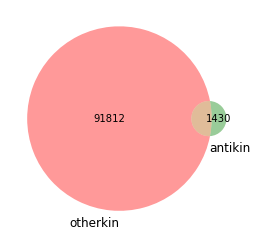

In [30]:
%matplotlib inline
v = venn2(subsets=(len_other-len_both,len_anti-len_both,len_both), set_labels=('otherkin', 'antikin', 'both'))
# v.get_label_by_id('10').set_text('')
# v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('')
# venn2_circles(subsets=(90449-884,2332-884,884))
plt.savefig('/usr2/mamille2/tumblr/otherkin_antikin.png', dpi=400)

In [45]:
def has_tag(text, tags):
    """ Takes in a Tumblr hashtag list and list of tags and returns whether any of them are present """
    
    return any(tag in split_tags(text) for tag in tags)

In [25]:
def has_tag_re(text, regex):
    """ Takes in a Tumblr hashtag text list and regex and returns whether there are any matches """
    
    if not isinstance(text, str):
        return False
    
    else:
        return any(re.match(regex, tag) for tag in split_tags(text))

## Investigate rows with no tags--is newlines in post_content causing error

In [27]:
notags = data[data['post_tags'].map(lambda x: isinstance(x, float))]
len(notags)

260748

In [32]:
# No tag data has *kin somewhere else?
notags_types = {}

# for field in ['post_id', 'body', 'post_caption', 'post_content']:
for field in ['post_id', 'post_title']:
    notags_types[field] = notags[notags[field].map(lambda x: 'kin' in x if isinstance(x, str) else False)]
    print("{0}:\t{1}".format(field, len(notags_types[field])))

post_id:	62706
post_title:	0


In [34]:
pd.set_option('display.max_colwidth', 999)

In [38]:
pd.set_option('display.max_columns', 999)

In [39]:
notags.iloc[:100,:]

,post_id,activity_time_epoch,tumblog_id,post_title,post_short_url,post_type,post_caption,post_format,post_note_count,created_time_epoch,updated_time_epoch,source_title,source_url,post_classifier,blog_classifier,reblogged_from_post_id,reblogged_from_metadata,root_post_id,body,include_first_tag,include_second_tag,mentions,post_tags,post_content
4,"<p><a class=""photoset_photo rapid-noclick-resp"" href=""http://33.media.tumblr.com/14dfe59ace608b7f746c312290678c48/tumblr_nfrukuVAUo1shdhdjo1_500.gif"" id=""photoset_link_103909364090_1"" data-photoset-index=""1""><img alt="""" src=""https://68.media.tumblr.com/14dfe59ace608b7f746c312290678c48/tumblr_nfrukuVAUo1shdhdjo1_500.gif"" data-pin-description=""Studio Ghibli GIFs"" data-pin-url=""http://studioghifli.com/post/103838762321""/></a></p>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"<p><a class=""photoset_photo rapid-noclick-resp"" href=""http://38.media.tumblr.com/f07b7d73cb549d422475f40122211fd0/tumblr_nfrukuVAUo1shdhdjo2_500.gif"" id=""photoset_link_103909364090_2"" data-photoset-index=""2""><img alt="""" src=""https://68.media.tumblr.com/f07b7d73cb549d422475f40122211fd0/tumblr_nfrukuVAUo1shdhdjo2_500.gif"" data-pin-description=""Studio Ghibli GIFs"" data-pin-url=""http://studioghifli.com/post/103838762321""/></a></p>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"</blockquote>,note_count#1766,slug#arguing-with-otherkin-be-like,source_url#http://equalityinomnicide.tumblr.com/post/104487936288/arguing-with-otherkin-be-like,tags#{(perfect),(anti kin)},source_title#equalityinomnicide]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"<p>They’re really great, especially since they’re a neutral, they go with anything!</p>,photos#[{""caption"":"""",""is_panorama"":false,""alt_sizes"":[{""width"":385,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_400.jpg"",""height"":385},{""width"":250,""url"":""http:\/\/65.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_250.jpg"",""height"":250},{""width"":100,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_100.jpg"",""height"":100},{""width"":75,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_75sq.jpg"",""height"":75}],""original_size"":{""width"":385,""url"":""http:\/\/66.media.tumblr.com\/95fd48c7371ee13ba487af19473c9746\/tumblr_n9lvtafHhd1tgpa7jo1_400.jpg"",""height"":385},""exif"":{}}],note_count#244,slug#grey-nebula-tights-7-theyre-really-great,tags#{(otherkin),(submission),(starkin),(spacekin),(celestialkin)}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,"<p><a href=""https://www.etsy.com/listing/171705731/the-universe-nail-polish-8-ml-vegan-non?ref=sr_gallery_30&amp;ga_search_query=space&amp;ga_order=most_relevant&amp;ga_ship_to=US&amp;ga_min=0&amp;ga_max=20&amp;ga_search_type=handmade&amp;ga_view_type=gallery"">buy it here!</a></p>,photos#[{""caption"":"""",""is_panorama"":false,""alt_sizes"":[{""width"":570,""url"":""http:\/\/65.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_1280.jpg"",""height"":518},{""width"":540,""url"":""http:\/\/65.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_540.jpg"",""height"":491},{""width"":500,""url"":""http:\/\/67.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_500.jpg"",""height"":454},{""width"":400,""url"":""http:\/\/66.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_400.jpg"",""height"":364},{""width"":250,""url"":""http:\/\/66.media.tumblr.com\/bc238889434d3a52c7012a98295053e5\/tumblr_na4dqh3Ixg1tgpa7jo1_250.jpg"",""...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Look at I'm ___ trash

In [ ]:
# Load data
data = pd.read_pickle('/usr2/mamille2/tumblr/data/halfday_text.pkl')
print(data.columns)
print(len(data))

In [ ]:
# Search for I'm ___ trash

trash_re = re.compile(r"(?:I'm|i'm|Im|im).{1,30}(?:trash|Trash|TRASH)")

def trash_present(text):
    """ Return T/F for presence I'm ____ trash """
    
    if not isinstance(text, str):
        return False
    
    if re.search(trash_re, text):
        return True
    else:
        return False

def trash_match(text):
    """ Return match object for I'm ____ trash """
    
    if not isinstance(text, str):
        return None
    
    return re.search(trash_re, text)

In [ ]:
trash_present("I'm star wars trash")

In [ ]:
trash_present("yada")

In [ ]:
trash_data = data[data['body'].map(trash_present)]
len(trash_data)

In [ ]:
trash_data

In [ ]:
type(trash_data.loc[:,'body'])

In [ ]:
pd.set_option('display.max_colwidth', 999)

In [ ]:
trash_data.loc[:,['body']]